${\Huge \text{Filter and process the raw dataset}}$ <br /><br />
${\Large \text{Pierre Guilmin}}$  
$\text{December 2018}$

**Goal:** This notebook computes the final dataset from the raw impact dataset, the final dataset will be used everywhere else in the analysis. It combines a lot of knowledge from a previous study to filter, clean, curate and annotate the raw dataset. All the operations are summarised in the `utils/r/compute_final_dataset.R` R script and can be applied on the raw dataset by using the `get_final_dataset()` function.

⚠️ This notebook is long, technical (*and a bit boring*), we wouln't advise you to read it to begin with the dataset understanding...

This notebook is divided in 3 parts:
* **1. Get click_annotvcf annotations**
* **2. Filter the dataset**
* **3. Process the raw features**

***

In [1]:
source("../../utils/r/custom_tools.R")
setup_environment("../../utils/r")

We are going to annotate the raw impact dataset with the click_annotvcf VEP annotations.

In [2]:
# load raw dataset
impact <- read.table("../../data/raw/all_IMPACT_mutations_20181105.txt",
                     sep = "\t", stringsAsFactors = FALSE, header = TRUE, comment = "#")
print_size(impact)
head(impact)

Size of impact: 678332 x 37

Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,cDNA_change,HGVSp_Short,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,occurence_in_normals,confidence_class,variant_status,sample_coverage,minor_contamination,match_status,variant_caller_cv
TP53,0,MSK-IMPACT,hg19,17,7577515,7577515,+,nonsynonymous_SNV,SNP,T,T,G,novel,P-0000012-T02-IM3,NA,T,T,c.766A>C,p.T256P,227,0.50220,114,569,0.00000,0,59,54,58,56,0,AUTO_OK,NEW_VARIANT,344,0.00810,Matched,1
ARID1A,0,MSK-IMPACT,hg19,1,27101572,27101572,+,synonymous_SNV,SNP,C,C,G,novel,P-0000012-T02-IM3,NA,C,C,c.4854C>G,p.P1618P,281,0.07829,22,879,0.00000,0,126,129,11,11,0,UNKNOWN,NEW_VARIANT,344,0.00810,Matched,1
PTPRS,0,MSK-IMPACT,hg19,19,5244030,5244030,+,synonymous_SNV,SNP,C,C,G,novel,P-0000012-T02-IM3,NA,C,C,c.1452G>C,p.L484L,299,0.37793,113,730,0.00274,2,97,87,61,52,0,UNKNOWN,NEW_VARIANT,344,0.00810,Matched,1
PIK3R3,0,MSK-IMPACT,hg19,1,46521514,46521514,+,nonsynonymous_SNV,SNP,G,G,C,novel,P-0000012-T03-IM3,NA,G,G,c.894C>G,p.I298M,733,0.17599,129,1243,0.00000,0,288,316,61,68,0,AUTO_OK,NEW_VARIANT,428,0.00398,Matched,1
ATR,0,MSK-IMPACT,hg19,3,142178126,142178126,+,nonsynonymous_SNV,SNP,C,C,A,novel,P-0000012-T03-IM3,NA,C,C,c.7292G>T,p.R2431M,482,0.17427,84,581,0.00172,1,221,177,46,38,0,AUTO_OK,NEW_VARIANT,428,0.00398,Matched,1
PDGFRA,0,MSK-IMPACT,hg19,4,55139732,55139732,+,nonsynonymous_SNV,SNP,T,T,A,novel,P-0000012-T03-IM3,NA,T,T,c.1393T>A,p.L465M,570,0.20351,116,811,0.00000,0,252,202,66,50,0,AUTO_OK,NEW_VARIANT,428,0.00398,Matched,1


In [3]:
# create a mutation key
impact$mut_key <- paste(impact$Chromosome, impact$Start_Position, impact$Reference_Allele, impact$Tumor_Seq_Allele2, sep = '_')
head(impact$mut_key)

[1] "17_7577515_T_G"  "1_27101572_C_G"  "19_5244030_C_G"  "1_46521514_G_C" 
[5] "3_142178126_C_A" "4_55139732_T_A"

# Get click_annotvcf VEP annotations

Get the features from `click_annotvcf_all_IMPACT_mutations_20181105.txt` (impact annotated by the click_annotvcf pipeline) and add them to `impact`.

## Get the raw data

In [4]:
# load annotated dataset
impact_annotated <- read.table("../../data/annotate_with_click_annotvcf/click_annotvcf_IMPACT_mutations_20181105.txt",
                               sep = "\t", stringsAsFactors = FALSE, header = TRUE, comment = "#")
print_size(impact_annotated)
head(impact_annotated)

Size of impact_annotated: 465005 x 156

ID_VARIANT    TARGET_NAME REFERENCE_NAME CHR START   END     REF ALT
1 1_2487766_T_C NA          NA             1   2487766 2487766 T   C  
2 1_2487944_C_T NA          NA             1   2487944 2487944 C   T  
3 1_2487954_G_A NA          NA             1   2487954 2487954 G   A  
4 1_2487959_T_A NA          NA             1   2487959 2487959 T   A  
5 1_2487984_C_A NA          NA             1   2487984 2487984 C   A  
6 1_2487986_G_A NA          NA             1   2487986 2487986 G   A  
  CONTEXT_5 CHANGE CONTEXT_3 QUAL CALLED_BY PASSED_BY NUMBER_OF_CALLERS
1 TGGAA     C      GGTGC     NA   NA        NA        0                
2 CTCTC     T      TGCTG     NA   NA        NA        0                
3 GCTCG     A      GTTCT     NA   NA        NA        0                
4 GGTTC     A      GAGGC     NA   NA        NA        0                
5 CGAGG     A      GGATT     NA   NA        NA        0                
6 AGGCG     A      ATTCT     NA   NA        NA        0                
  FLAGS_ALL TARGET_VAF_MEAN TARGET_VAF_STD REFERENCE_VAF_MEAN REFERENCE_VAF_STD
1 PASS      NA              NA             NA                 NA               
2 PASS      NA              NA             NA                 NA               
3 PASS      NA              NA             NA                 NA               
4 PASS      NA              NA             NA                 NA               
5 PASS      NA              NA             NA                 NA               
6 PASS      NA              NA             NA                 NA               
  mutect_TARGET_VAF mutect_TARGET_DEPTH mutect_REFERENCE_VAF
1 NA                NA                  NA                  
2 NA                NA                  NA                  
3 NA                NA                  NA                  
4 NA                NA                  NA                  
5 NA                NA                  NA                  
6 NA                NA                  NA                  
  mutect_REFERENCE_DEPTH mutect_DIRPROP mutect_READS_FORWARD
1 NA                     NA             NA                  
2 NA                     NA             NA                  
3 NA                     NA             NA                  
4 NA                     NA             NA                  
5 NA                     NA             NA                  
6 NA                     NA             NA                  
  mutect_READS_REVERSE strelka_TARGET_VAF strelka_TARGET_DEPTH
1 NA                   NA                 NA                  
2 NA                   NA                 NA                  
3 NA                   NA                 NA                  
4 NA                   NA                 NA                  
5 NA                   NA                 NA                  
6 NA                   NA                 NA                  
  strelka_REFERENCE_VAF strelka_REFERENCE_DEPTH caveman_TARGET_VAF
1 NA                    NA                      NA                
2 NA                    NA                      NA                
3 NA                    NA                      NA                
4 NA                    NA                      NA                
5 NA                    NA                      NA                
6 NA                    NA                      NA                
  caveman_TARGET_DEPTH caveman_REFERENCE_VAF caveman_REFERENCE_DEPTH
1 NA                   NA                    NA                     
2 NA                   NA                    NA                     
3 NA                   NA                    NA                     
4 NA                   NA                    NA                     
5 NA                   NA                    NA                     
6 NA                   NA                    NA                     
  caveman_DIRPROP caveman_READS_FORWARD caveman_READS_REVERSE CAVEMAN_DS
1 NA              NA                    NA                    NA        
2 NA              NA                    NA      

We keep the following group of features:

In [5]:
# variant identification columns (chromosome, start position, ...)
id_colnames  <- c("ID_VARIANT",
                  "CHR",
                  "START",
                  "END",
                  "REF",
                  "ALT")

# VEP v92 annotations (mutation consequence, gene, p-change, ...)
vep_colnames <- c("VEP_Consequence",
                  "VEP_SYMBOL",
                  "VEP_HGVSc",
                  "VEP_HGVSp",
                  "VEP_VARIANT_CLASS")

# VEP v92 annotations (polyphen: 2.2.2, sift: 5.2.2, COSMIC v81)
vep_add_colnames <- c("VEP_IMPACT",             # subjective impact classification of consequence type
                      "VEP_Existing_variation", # identifier(s) of co-located known variants
                      "VEP_CLIN_SIG",           # clinVar clinical significance of the dbSNP variant
                      "VEP_SIFT",
                      "VEP_PolyPhen",
                      "VEP_COSMIC_CNT")

# VEP v92 annotations
#(annotated with
#   - /ifs/work/leukgen/home/leukbot/tests/vep/gnomad_genomes/gnomad.genomes.r2.0.1.sites.noVEP.vcf.gz and
#   - /ifs/work/leukgen/home/leukbot/tests/vep/gnomad_exomes/gnomad.exomes.r2.0.1.sites.noVEP.vcf.gz
vep_gnomad_colnames <- c("VEP_gnomAD_AF", # frequency of existing variant in gnomAD exomes combined population (VEP only annotation)
                         
                         # VEP_gnomAD_genome_AC.AN_<POP>: Allele count | Total number of alleles among <POP> genomes
                         "VEP_gnomAD_genome_AC.AN_AFR",
                         "VEP_gnomAD_genome_AC.AN_AMR",
                         "VEP_gnomAD_genome_AC.AN_ASJ",
                         "VEP_gnomAD_genome_AC.AN_EAS",
                         "VEP_gnomAD_genome_AC.AN_FIN",
                         "VEP_gnomAD_genome_AC.AN_NFE",
                         "VEP_gnomAD_genome_AC.AN_OTH",
                        
                         # VEP_gnomAD_exome_AC.AN_<POP>: Allele count | Total number of alleles among <POP> exomes
                         "VEP_gnomAD_exome_AC.AN_AFR",
                         "VEP_gnomAD_exome_AC.AN_AMR",
                         "VEP_gnomAD_exome_AC.AN_ASJ",
                         "VEP_gnomAD_exome_AC.AN_EAS",
                         "VEP_gnomAD_exome_AC.AN_FIN",
                         "VEP_gnomAD_exome_AC.AN_NFE",
                         "VEP_gnomAD_exome_AC.AN_OTH")

colnames_to_keep <- c(id_colnames, vep_colnames, vep_add_colnames, vep_gnomad_colnames)

impact_annotated <- impact_annotated[, colnames_to_keep]

For the gnomAD features, `<POP>` is being one of:
- AFR: African/African American
- AMR: Admixed American
- ASJ: Ashkenazi Jewish
- EAS: East Asian
- FIN: Finnish
- NFE: Non-Finnish European
- OTH: Other (population not assigned)

## Add the `OLD_REF`, `OLD_ALT` and `OLD_POS` features from the `.vcf` to `impact_annotated`

During the conversion to the `.vcf` (necessary to annotate with click_annotvcf), we modified the `REF`, `ALT` and `POS` features. The old version have been stored in the `INFO` column of the `.vcf`. We parse this column and add the 3 features `OLD_REF`, `OLD_ALT` and `OLD_POS` to `impact_annotated`.

In [6]:
impact_vcf <- read.table("../../data/annotate_with_click_annotvcf/all_IMPACT_mutations_20181105.vcf",
                               sep = "\t", stringsAsFactors = FALSE, header = FALSE, comment = "#")
colnames(impact_vcf) <- c("CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT")

In [7]:
print_size(impact_vcf)
head(impact_vcf)

Size of impact_vcf: 465005 x 9

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT
17,7577515,.,T,G,.,.,OLD_REF_ALT_POS=T/G/7577515,.
1,27101572,.,C,G,.,.,OLD_REF_ALT_POS=C/G/27101572,.
19,5244030,.,C,G,.,.,OLD_REF_ALT_POS=C/G/5244030,.
1,46521514,.,G,C,.,.,OLD_REF_ALT_POS=G/C/46521514,.
3,142178126,.,C,A,.,.,OLD_REF_ALT_POS=C/A/142178126,.
4,55139732,.,T,A,.,.,OLD_REF_ALT_POS=T/A/55139732,.


In [8]:
impact_vcf$OLD_REF <- sapply(impact_vcf$INFO, function(x) strsplit(strsplit(x, '=')[[1]][2], '/')[[1]][1])
impact_vcf$OLD_ALT <- sapply(impact_vcf$INFO, function(x) strsplit(strsplit(x, '=')[[1]][2], '/')[[1]][2])
impact_vcf$OLD_POS <- sapply(impact_vcf$INFO, function(x) strsplit(strsplit(x, '=')[[1]][2], '/')[[1]][3])
head(impact_vcf)

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,OLD_REF,OLD_ALT,OLD_POS
17,7577515,.,T,G,.,.,OLD_REF_ALT_POS=T/G/7577515,.,T,G,7577515
1,27101572,.,C,G,.,.,OLD_REF_ALT_POS=C/G/27101572,.,C,G,27101572
19,5244030,.,C,G,.,.,OLD_REF_ALT_POS=C/G/5244030,.,C,G,5244030
1,46521514,.,G,C,.,.,OLD_REF_ALT_POS=G/C/46521514,.,G,C,46521514
3,142178126,.,C,A,.,.,OLD_REF_ALT_POS=C/A/142178126,.,C,A,142178126
4,55139732,.,T,A,.,.,OLD_REF_ALT_POS=T/A/55139732,.,T,A,55139732


Let's create a `join_key` to join `impact_vcf` and `impact_annotated`:

In [9]:
impact_vcf$join_key <- paste(impact_vcf$CHROM, impact_vcf$POS, impact_vcf$REF, impact_vcf$ALT, sep = '_')
head(impact_vcf$join_key)

[1] "17_7577515_T_G"  "1_27101572_C_G"  "19_5244030_C_G"  "1_46521514_G_C" 
[5] "3_142178126_C_A" "4_55139732_T_A"

**Verification 1** The features must be unique for each `join_key`, but they are not:

In [10]:
impact_vcf <- unique(impact_vcf)

dd <- impact_vcf %>% group_by(join_key) %>% filter(n() > 1)
nrow(dd)

[1] 140

In [11]:
head(dd[order(dd$join_key),])

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,OLD_REF,OLD_ALT,OLD_POS,join_key
1,27099954,.,AC,A,.,.,OLD_REF_ALT_POS=AC/A/27099954,.,AC,A,27099954,1_27099954_AC_A
1,27099954,.,AC,A,.,.,OLD_REF_ALT_POS=C/-/27099955,.,C,-,27099955,1_27099954_AC_A
1,27106470,.,ACCACTAACTT,A,.,.,OLD_REF_ALT_POS=CCACTAACTT/-/27106471,.,CCACTAACTT,-,27106471,1_27106470_ACCACTAACTT_A
1,27106470,.,ACCACTAACTT,A,.,.,OLD_REF_ALT_POS=ACCACTAACTT/A/27106470,.,ACCACTAACTT,A,27106470,1_27106470_ACCACTAACTT_A
1,27106597,.,CAGTTGGACCT,C,.,.,OLD_REF_ALT_POS=CAGTTGGACCT/C/27106597,.,CAGTTGGACCT,C,27106597,1_27106597_CAGTTGGACCT_C
1,27106597,.,CAGTTGGACCT,C,.,.,OLD_REF_ALT_POS=AGTTGGACCT/-/27106598,.,AGTTGGACCT,-,27106598,1_27106597_CAGTTGGACCT_C


70 mutations were not consistently annotated in impact (when considering the `REF`, `ALT` and `POS` features), these lines will be duplicated in `impact_annotated` to take these mutations into account.

In [12]:
# example of inconsistently annotated mutation that is duplicated in `impact_annotated`
impact[impact$mut_key == "1_27099954_AC_A",]
impact[impact$mut_key == "1_27099955_C_-",]

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,cDNA_change,HGVSp_Short,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,occurence_in_normals,confidence_class,variant_status,sample_coverage,minor_contamination,match_status,variant_caller_cv,mut_key
197600,ARID1A,0,MSK-IMPACT,hg19,1,27099954,27099955,+,nonsynonymous_SNV,DEL,AC,AC,A,novel,P-0012550-T01-IM5,NA,AC,AC,c.3832_3834delinsTA,p.H1278Y,639,0.21909,140,512,0,0,242,255,64,76,0,MANUAL_OK,NEW_VARIANT,891,0.00199,Matched,1,1_27099954_AC_A


,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,cDNA_change,HGVSp_Short,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,occurence_in_normals,confidence_class,variant_status,sample_coverage,minor_contamination,match_status,variant_caller_cv,mut_key
197662,ARID1A,0,MSK-IMPACT,hg19,1,27099955,27099955,+,frameshift_deletion,DEL,C,C,-,novel,P-0012550-T01-IM5,NA,C,C,c.3834delC,p.Y1279fs,640,0.20781,133,513,0,0,244,259,62,71,0,UNLIKELY,NEW_VARIANT,891,0.00199,Matched,2,1_27099955_C_-


**Verification 2** Make sure every `impact_annotated` `ID_VARIANT` has an analoguous `join_key` in `impact_vcf`:

In [13]:
impact_annotated <- unique(impact_annotated)
nrow(impact_annotated)

[1] 464935

In [14]:
table(impact_annotated$ID_VARIANT %in% impact_vcf$join_key)


  TRUE 
464935 

In [15]:
impact_annotated <- left_join(impact_annotated, impact_vcf[, c("join_key", "OLD_REF", "OLD_ALT", "OLD_POS")], by = c("ID_VARIANT" = "join_key"))

In [16]:
head(impact_annotated)

ID_VARIANT,CHR,START,END,REF,ALT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_VARIANT_CLASS,VEP_IMPACT,VEP_Existing_variation,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH,OLD_REF,OLD_ALT,OLD_POS
1_2487766_T_C,1,2487766,2487766,T,C,non_coding_transcript_exon_variant,RP3-395M20.8,ENST00000416860.2:n.405A>G,NA,SNV,MODIFIER,rs2227313,NA,NA,NA,NA,0.5321,6033 | 8696,445 | 836,138 | 302,753 | 1610,1723 | 3490,7259 | 14884,511 | 974,4126 | 5816,12577 | 23330,3503 | 7708,4955 | 9888,2509 | 5232,21251 | 44186,1742 | 3444,T,C,2487766
1_2487944_C_T,1,2487944,2487944,C,T,5_prime_UTR_variant,TNFRSF14,ENST00000355716.4:c.-160C>T,NA,SNV,MODIFIER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,C,T,2487944
1_2487954_G_A,1,2487954,2487954,G,A,5_prime_UTR_variant,TNFRSF14,ENST00000355716.4:c.-150G>A,NA,SNV,MODIFIER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0 | 6682,4 | 23862,0 | 8122,0 | 10148,0 | 9864,0 | 54396,0 | 3734,G,A,2487954
1_2487959_T_A,1,2487959,2487959,T,A,5_prime_UTR_variant,TNFRSF14,ENST00000355716.4:c.-145T>A,NA,SNV,MODIFIER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,T,A,2487959
1_2487984_C_A,1,2487984,2487984,C,A,5_prime_UTR_variant,TNFRSF14,ENST00000355716.4:c.-120C>A,NA,SNV,MODIFIER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,C,A,2487984
1_2487986_G_A,1,2487986,2487986,G,A,5_prime_UTR_variant,TNFRSF14,ENST00000355716.4:c.-118G>A,NA,SNV,MODIFIER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,G,A,2487986


As seen before, 70 new duplicated lines for the inconsistently annotated mutations:

In [17]:
nrow(impact_annotated) - 464935

# previous example of inconsistently annotated mutation where we managed to get the two different keys to link with impact
impact_annotated[impact_annotated$ID_VARIANT == "1_27099954_AC_A",]

[1] 70

,ID_VARIANT,CHR,START,END,REF,ALT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_VARIANT_CLASS,VEP_IMPACT,VEP_Existing_variation,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH,OLD_REF,OLD_ALT,OLD_POS
9492,1_27099954_AC_A,1,27099954,27099955,AC,A,frameshift_variant,ARID1A,ENST00000324856.7:c.3834del,ENSP00000320485.7:p.Tyr1279IlefsTer10,deletion,HIGH,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,AC,A,27099954
9493,1_27099954_AC_A,1,27099954,27099955,AC,A,frameshift_variant,ARID1A,ENST00000324856.7:c.3834del,ENSP00000320485.7:p.Tyr1279IlefsTer10,deletion,HIGH,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,C,-,27099955


## Create keys to join `impact` and `impact_annotated`

We are going to identify each mutation with a key in both dataframes, allowing us to link each mutation from `impact` to its corresponding mutation in `impact_annotated`. The keys will be: 
* `mut_key` for `impact` (already created)
* `join_key = CHR`\_`OLD_POS`\_`OLD_REF`\_`OLD_ALT` for `impact_annotated`

In [18]:
impact_annotated$join_key <- paste(impact_annotated$CHR, impact_annotated$OLD_POS, impact_annotated$OLD_REF, impact_annotated$OLD_ALT, sep = '_')
head(impact_annotated$join_key)

[1] "1_2487766_T_C" "1_2487944_C_T" "1_2487954_G_A" "1_2487959_T_A"
[5] "1_2487984_C_A" "1_2487986_G_A"

**Verification 1** Make sure every impact `mut_key` has an analoguous `join_key` in `impact_annotated`:

In [19]:
table(impact$mut_key %in% impact_annotated$join_key)


  TRUE 
678332 

**Verification 2** The features must be unique for each `join_key`, they are:

In [20]:
impact_annotated <- unique(impact_annotated)
nrow(impact_annotated %>% group_by(join_key) %>% filter(n() > 1))

[1] 0

In [21]:
colnames_to_keep <- c(vep_colnames, vep_add_colnames, vep_gnomad_colnames)

In [22]:
impact <- left_join(impact, impact_annotated[, c("join_key", colnames_to_keep)], by = c("mut_key" = "join_key"))

In [23]:
print_size(impact)
head(impact)

Size of impact: 678332 x 64

Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,cDNA_change,HGVSp_Short,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,occurence_in_normals,confidence_class,variant_status,sample_coverage,minor_contamination,match_status,variant_caller_cv,mut_key,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_VARIANT_CLASS,VEP_IMPACT,VEP_Existing_variation,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH
TP53,0,MSK-IMPACT,hg19,17,7577515,7577515,+,nonsynonymous_SNV,SNP,T,T,G,novel,P-0000012-T02-IM3,NA,T,T,c.766A>C,p.T256P,227,0.50220,114,569,0.00000,0,59,54,58,56,0,AUTO_OK,NEW_VARIANT,344,0.00810,Matched,1,17_7577515_T_G,missense_variant,TP53,ENST00000269305.4:c.766A>C,ENSP00000269305.4:p.Thr256Pro,SNV,MODERATE,CM102355&CD120857&TP53_g.13403A>C&COSM44544&COSM44662&COSM45526&COSM45830,NA,deleterious(0),probably_damaging(0.999),1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ARID1A,0,MSK-IMPACT,hg19,1,27101572,27101572,+,synonymous_SNV,SNP,C,C,G,novel,P-0000012-T02-IM3,NA,C,C,c.4854C>G,p.P1618P,281,0.07829,22,879,0.00000,0,126,129,11,11,0,UNKNOWN,NEW_VARIANT,344,0.00810,Matched,1,1_27101572_C_G,synonymous_variant,ARID1A,ENST00000324856.7:c.4854C>G,ENSP00000320485.7:p.Pro1618%3D,SNV,LOW,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
PTPRS,0,MSK-IMPACT,hg19,19,5244030,5244030,+,synonymous_SNV,SNP,C,C,G,novel,P-0000012-T02-IM3,NA,C,C,c.1452G>C,p.L484L,299,0.37793,113,730,0.00274,2,97,87,61,52,0,UNKNOWN,NEW_VARIANT,344,0.00810,Matched,1,19_5244030_C_G,synonymous_variant,PTPRS,ENST00000357368.4:c.1452G>C,ENSP00000349932.4:p.Leu484%3D,SNV,LOW,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
PIK3R3,0,MSK-IMPACT,hg19,1,46521514,46521514,+,nonsynonymous_SNV,SNP,G,G,C,novel,P-0000012-T03-IM3,NA,G,G,c.894C>G,p.I298M,733,0.17599,129,1243,0.00000,0,288,316,61,68,0,AUTO_OK,NEW_VARIANT,428,0.00398,Matched,1,1_46521514_G_C,missense_variant,PIK3R3,ENST00000262741.5:c.894C>G,ENSP00000262741.5:p.Ile298Met,SNV,MODERATE,NA,NA,deleterious(0),benign(0.277),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ATR,0,MSK-IMPACT,hg19,3,142178126,142178126,+,nonsynonymous_SNV,SNP,C,C,A,novel,P-0000012-T03-IM3,NA,C,C,c.7292G>T,p.R2431M,482,0.17427,84,581,0.00172,1,221,177,46,38,0,AUTO_OK,NEW_VARIANT,428,0.00398,Matched,1,3_142178126_C_A,missense_variant,ATR,ENST00000350721.4:c.7292G>T,ENSP00000343741.4:p.Arg2431Met,SNV,MODERATE,rs759327414&COSM1039347,NA,deleterious(0),probably_damaging(0.997),NA,4.063e-06,NA,NA,NA,NA,NA,NA,NA,0 | 15296,0 | 33564,0 | 9844,0 | 17248,0 | 22288,1 | 111610,0 | 5480
PDGFRA,0,MSK-IMPACT,hg19,4,55139732,55139732,+,nonsynonymous_SNV,SNP,T,T,A,novel,P-0000012-T03-IM3,NA,T,T,c.1393T>A,p.L465M,570,0.20351,116,811,0.00000,0,252,202,66,50,0,AUTO_OK,NEW_VARIANT,428,0.00398,Matched,1,4_55139732_T_A,missense_variant,PDGFRA,ENST00000257290.5:c.1393T>A,ENSP00000257290.5:p.Leu465Met,SNV,MODERATE,NA,NA,deleterious(0.01),probably_damaging(0.965),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# Filter the dataset

## [Remove] the unique-value and redundant features

Let's find the features that share a unique value accross the dataset:

In [24]:
count_per_feature <- apply(impact, 2, function(d) length(unique(d))) # get number of unique values per feature
unique_value_features <- names(count_per_feature[count_per_feature == 1])
impact[1, unique_value_features]

Entrez_Gene_Id,Center,NCBI_Build,Strand,dbSNP_RS,Matched_Norm_Sample_Barcode,variant_status
0,MSK-IMPACT,hg19,+,novel,NA,NEW_VARIANT


In [25]:
# [-7 features] remove the unique-value features
impact[, c("Entrez_Gene_Id",
           "Center",
           "NCBI_Build",
           "Strand",
           "dbSNP_RS",
           "Matched_Norm_Sample_Barcode",
           "variant_status")] <- list(NULL)

In [26]:
# [-3 features] remove the redundant features
impact[, c("Match_Norm_Seq_Allele1", "Match_Norm_Seq_Allele2", "Tumor_Seq_Allele1")] <- list(NULL)

## [Modify & Remove] keep the coding and splicing `VEP_Consequence` mutations

The `VEP_Consequence` has been calculated for the most deleterious transcript (cf. click_annotvcf pipeline). Then, we have for each mutation a list of possible consequence **for the selected transcript** (so the most deleterious). This list of mutation is ordered by the most deleterious consequence first, it's the one we keep.

In [27]:
# example of the transformation applied
dd <- tail(unique(impact$VEP_Consequence), 10)
dd <- data.frame(dd, sapply(dd, function(x) strsplit(x, '&')[[1]][1]), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
splice_region_variant&synonymous_variant&NMD_transcript_variant,splice_region_variant
splice_region_variant&stop_retained_variant,splice_region_variant
missense_variant&stop_retained_variant,missense_variant
splice_donor_variant&3_prime_UTR_variant&intron_variant,splice_donor_variant
splice_region_variant&coding_sequence_variant&intron_variant,splice_region_variant
frameshift_variant&splice_region_variant&NMD_transcript_variant,frameshift_variant
splice_acceptor_variant&non_coding_transcript_exon_variant&intron_variant,splice_acceptor_variant
splice_donor_variant&intron_variant&NMD_transcript_variant,splice_donor_variant
coding_sequence_variant,coding_sequence_variant
splice_acceptor_variant&coding_sequence_variant&NMD_transcript_variant,splice_acceptor_variant


In [28]:
# [~ every rows] select only the most deleterious VEP consequence
impact$VEP_Consequence <- sapply(impact$VEP_Consequence, function(x) strsplit(x, '&')[[1]][1])

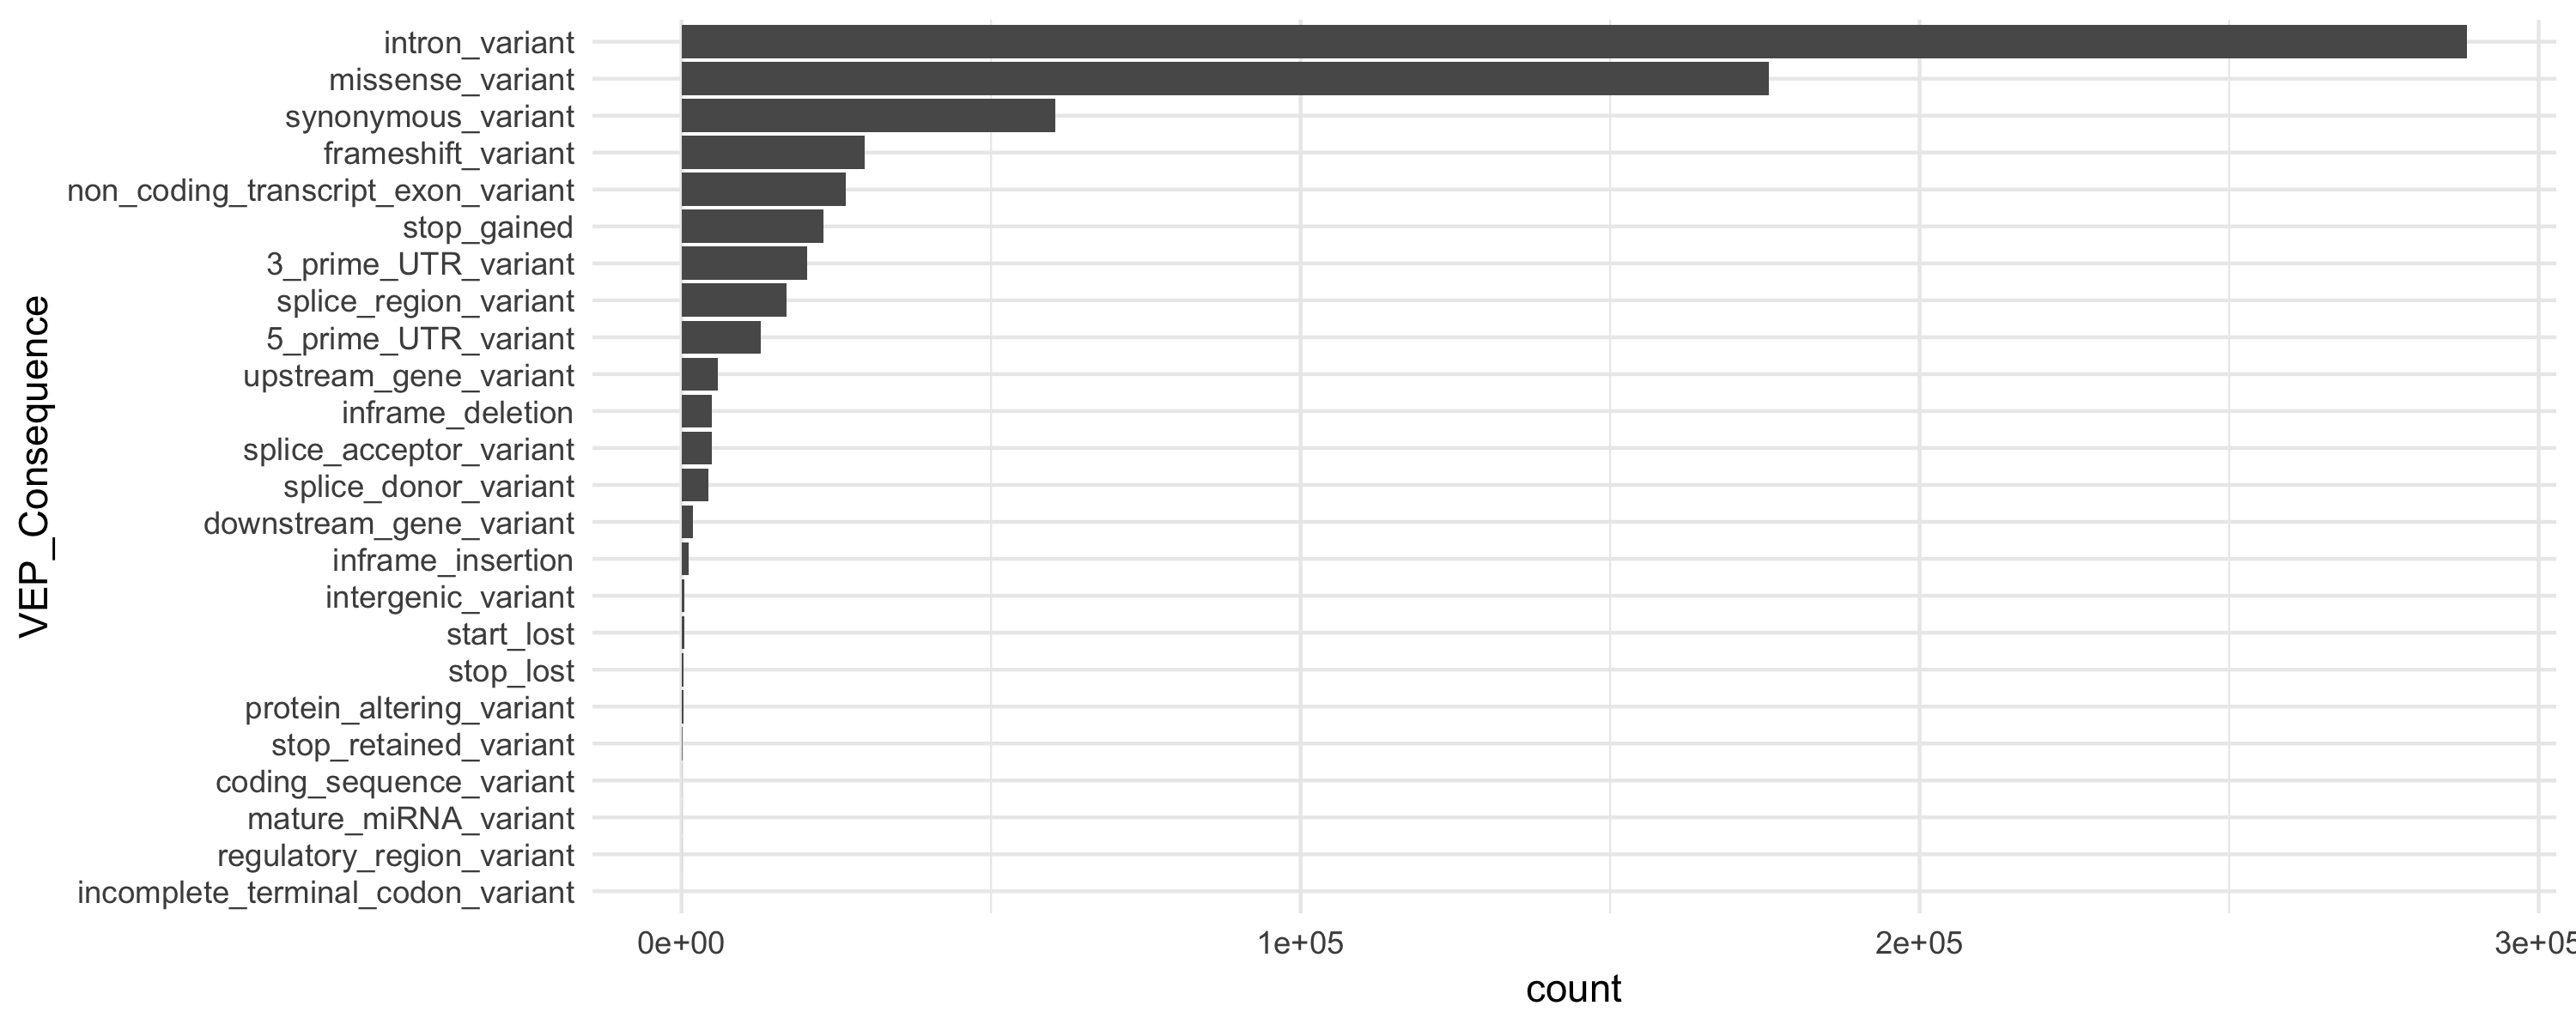

In [29]:
plot_histogram(impact, "VEP_Consequence", height = 4, flip = TRUE)

In [30]:
# [-434,123 rows] keep only the coding and splicing VEP_Consequence mutations
impact <- impact[impact$VEP_Consequence %in% c("missense_variant",
                                               "frameshift_variant",
                                               "stop_gained",
                                               "splice_acceptor_variant",
                                               "inframe_deletion",
                                               "splice_donor_variant",
                                               "inframe_insertion",
                                               "start_lost",
                                               "stop_lost"),]

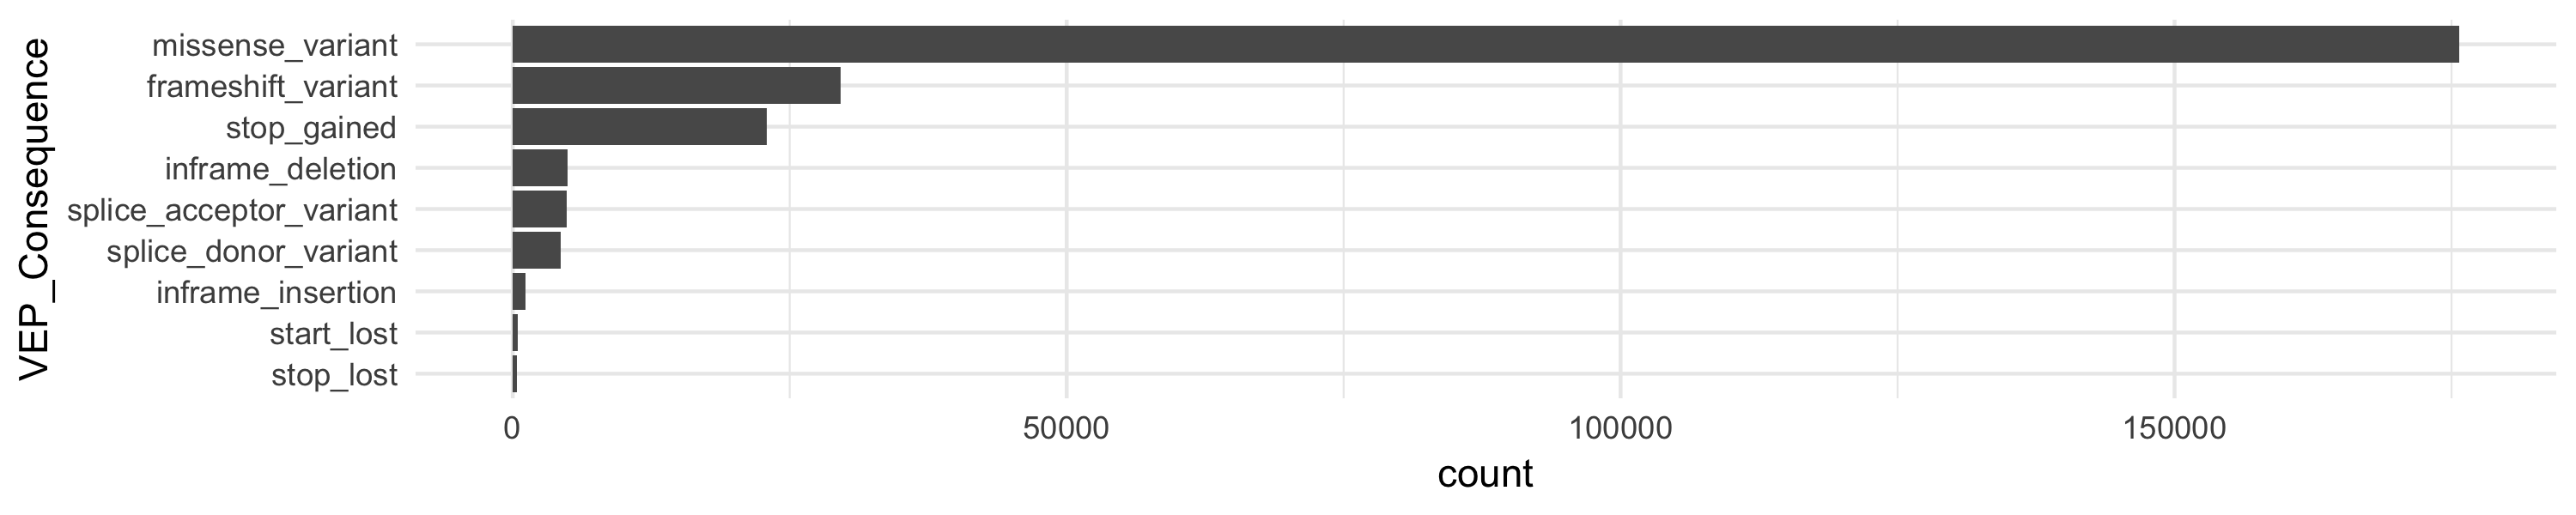

In [31]:
plot_histogram(impact, "VEP_Consequence", height = 2, flip = TRUE)

In [32]:
nrow(impact) # it was 678,332 before

[1] 244209

## [Remove] `match_status = Unmatched` or `match_status = Unknown`

Some mutation are not matched normal, we remove them:

In [33]:
get_table(impact$match_status)

values,count,freq
Matched,236657,96.9%
Unmatched,7550,3.1%
Unknown,2,0%
-- total --,244209,100%


We can look at the vaf density for the matched vs unmatched samples:

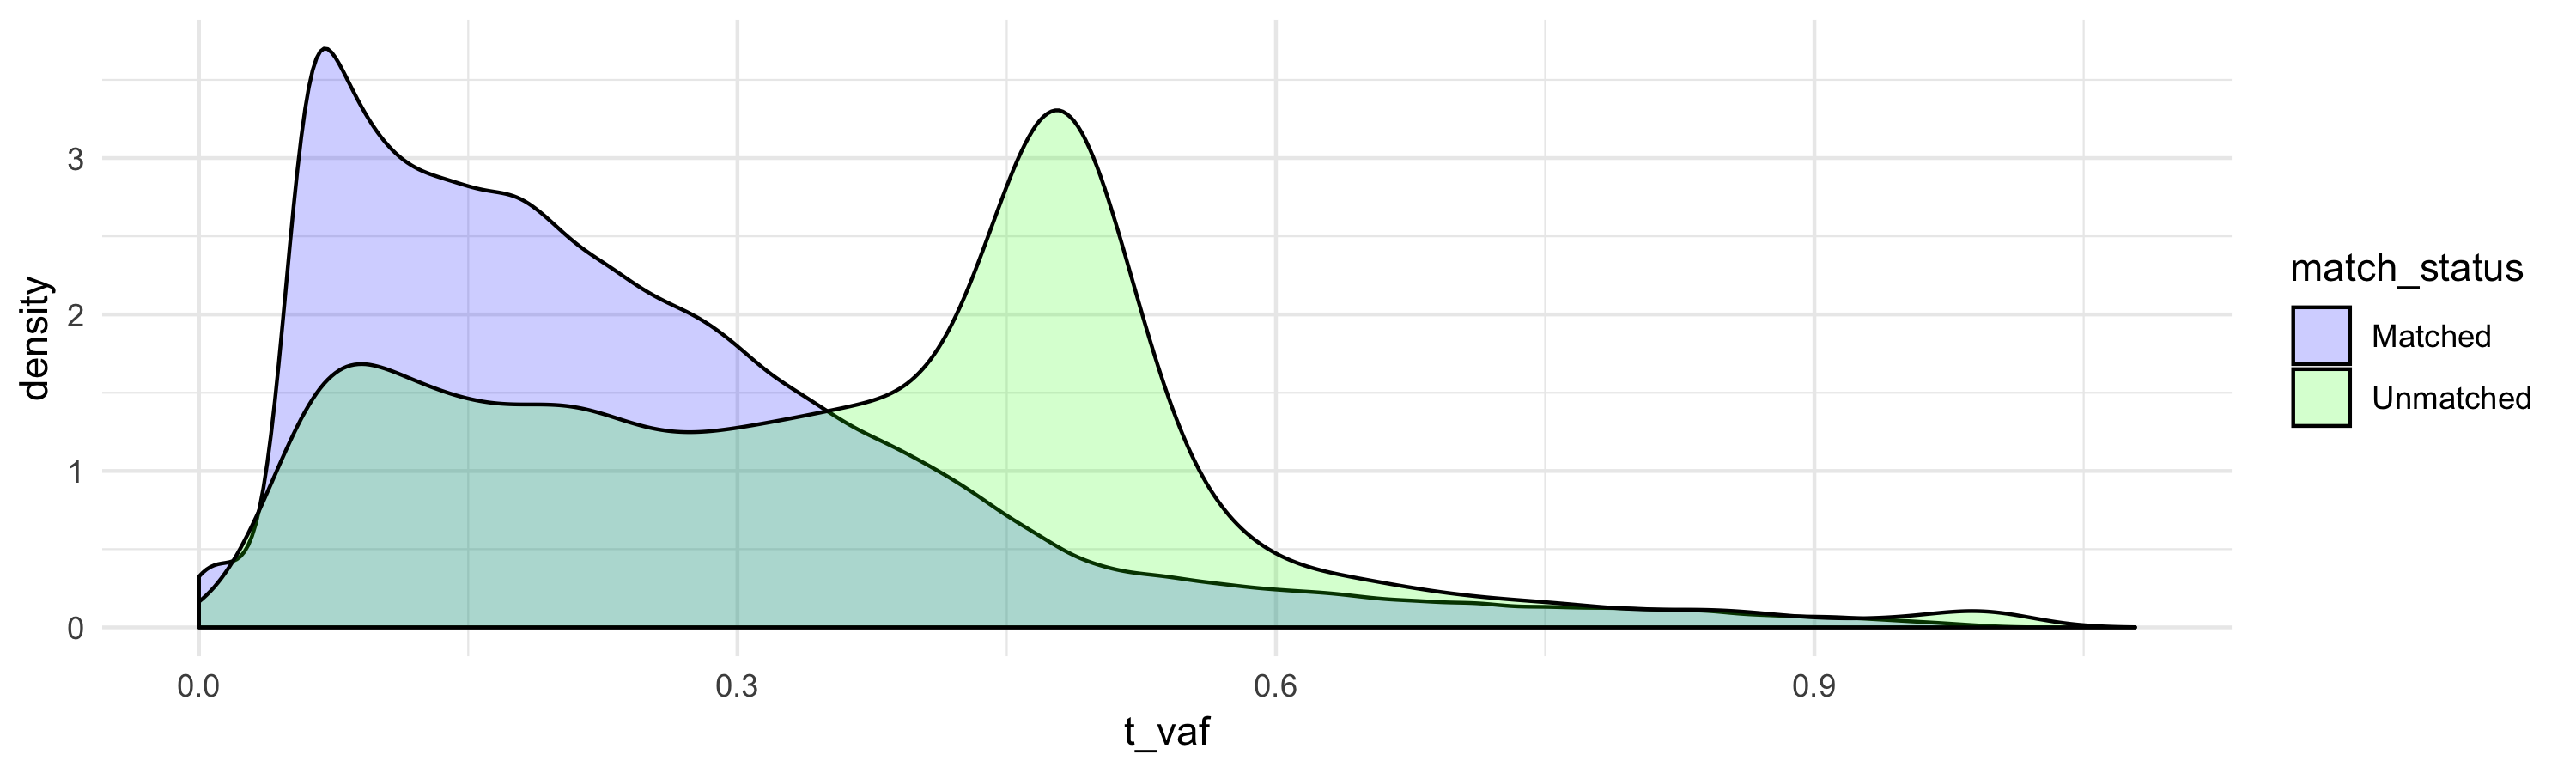

In [34]:
plot_density(impact[impact$match_status != "Unknown",], "t_vaf", "match_status")

In [35]:
# [-7,552 rows] remove rows having `match_status = "Unmatched"` or `match_status = "Unknown"`
impact <- impact[! impact$match_status %in% c("Unmatched", "Unknown"),]
# [-1 features] remove the `match_status` feature
impact$match_status <- NULL

## [Modify & Remove] `confidence_class`

In [36]:
get_table(impact$confidence_class)

values,count,freq
AUTO_OK,211377,89.3%
UNLIKELY,10551,4.5%
MANUAL_OK,8105,3.4%
UNKNOWN,5691,2.4%
UNLIKELY_MERGED,549,0.2%
OK_NOT_SO,291,0.1%
UNLIKELY_ARTIFACT,65,0%
UNLIKELY_NOISE,22,0%
UNLIKELY_IN_NORMAL,6,0%
-- total --,236657,100%


In [37]:
# [~642 rows] rename `confidence_class` in {"UNLIKELY_MERGED", "UNLIKELY_ARTIFACT", "UNLIKELY_NOISE", "UNLIKELY_IN_NORMAL"} to "UNLIKELY"
impact$confidence_class[impact$confidence_class %in% c("UNLIKELY_MERGED", "UNLIKELY_ARTIFACT", "UNLIKELY_NOISE", "UNLIKELY_IN_NORMAL")] <- "UNLIKELY"
get_table(impact$confidence_class)

values,count,freq
AUTO_OK,211377,89.3%
UNLIKELY,11193,4.7%
MANUAL_OK,8105,3.4%
UNKNOWN,5691,2.4%
OK_NOT_SO,291,0.1%
-- total --,236657,100%


In [38]:
# [-5,982 rows] remove rows having `confidence_class = "UNKNOWN"` or `confidence_class = "OK_NOT_SO"`
impact <- impact[! impact$confidence_class %in% c("UNKNOWN", "OK_NOT_SO"),]

## [Remove] `minor_contamination` > 0.01

From Ahmet:
> minor_contamination : this is our calculation of presence of possible another sample in the tumor. This should be less than or equal to 0.01.

In [39]:
nrow(impact[impact$minor_contamination > 0.01,])

[1] 0

In [40]:
# [-0 rows] remove the contaminated rows ie minor_contamination > 0.01
impact <- impact[impact$minor_contamination <= 0.01,]
# [-1 feature] remove the minor_contamination feature
impact["minor_contamination"] <- NULL

## [Remove] `n_depth` < 20

There is something weird with some rows having 0 or really a low `n_depth` reads, we decided to set a threshold for `n_depth`, every row with `n_depth < 20` is removed (same threshold as for `t_depth`):

In [41]:
nrow(impact[impact$n_depth < 20,])

[1] 372

In [42]:
# [-372 rows] remove the rows having n_depth < 20
impact <- impact[impact$n_depth >= 20,]

## [Remove] `t_alt_plus_count` + `t_alt_neg_count` != `t_alt_count`

In [43]:
wrong_t_alt_count <- impact[impact$t_alt_plus_count + impact$t_alt_neg_count != impact$t_alt_count,]
nrow(wrong_t_alt_count)

[1] 38

38 rows have `t_alt_plus_count + t_alt_neg_count != t_alt_count`. We will quantify this error by computing the absolute difference between these two values:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    3.0   119.5   252.0   527.9   364.2 10447.0 

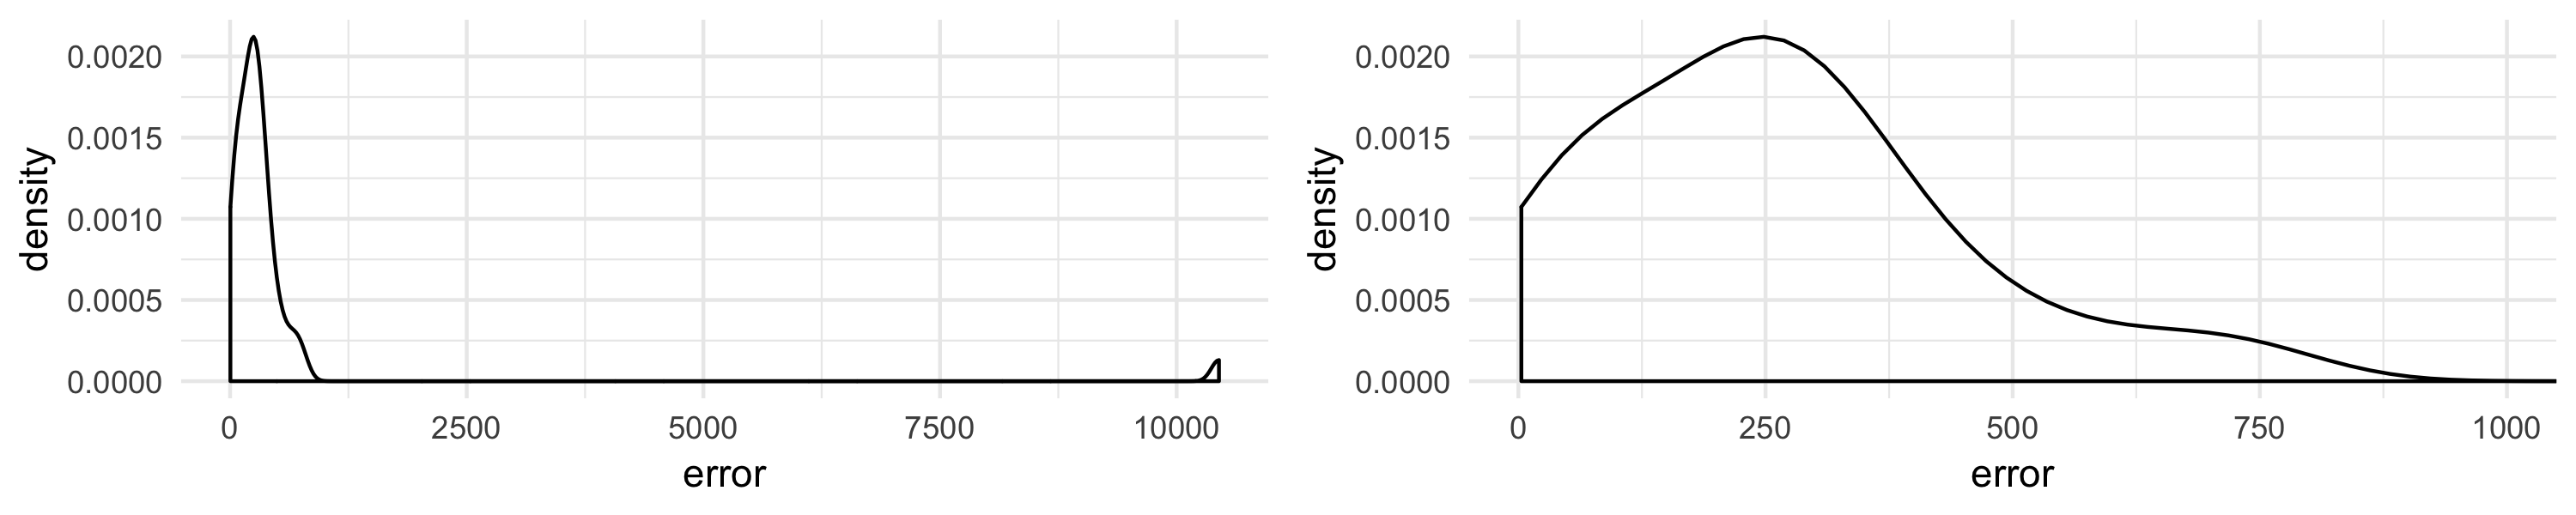

In [44]:
wrong_t_alt_count$error <- abs(wrong_t_alt_count$t_alt_plus_count + wrong_t_alt_count$t_alt_neg_count -
                               wrong_t_alt_count$t_alt_count)

summary(wrong_t_alt_count$error)
plot1 <- plot_density(wrong_t_alt_count, "error")
plot2 <- plot_density(wrong_t_alt_count, "error") + coord_cartesian(xlim = c(0, 1000))
plot_side_by_side(plot1, plot2)

The difference is not negligible, with a median of 238, we decided to remove these 38 rows.

In [45]:
# [-38 rows] remove the rows having t_alt_plus_count + t_alt_neg_count != t_alt_count
impact <- impact[impact$t_alt_plus_count + impact$t_alt_neg_count == impact$t_alt_count,]

## [Remove] `t_alt_plus_count == 0` and `t_alt_neg_count == 0`

In [46]:
nrow(impact[impact$t_alt_count == 0,])
nrow(impact[impact$t_vaf == 0,])

[1] 541

[1] 541

In [47]:
# [-541 rows] remove the rows having t_alt_count = 0
impact <- impact[impact$t_alt_count != 0,]

## [Create] new features: `sample_mut_key`, `patient_key`

In [48]:
# [+1 feature] create a sample mutation key feature to idenfity rows in a unique way
impact$sample_mut_key <- paste(impact$Tumor_Sample_Barcode, impact$mut_key, sep = '_')
head(impact$sample_mut_key)

[1] "P-0000012-T02-IM3_17_7577515_T_G"  "P-0000012-T03-IM3_1_46521514_G_C" 
[3] "P-0000012-T03-IM3_3_142178126_C_A" "P-0000012-T03-IM3_4_55139732_T_A" 
[5] "P-0000012-T03-IM3_4_153249542_C_A" "P-0000012-T03-IM3_4_153332775_C_A"

In [49]:
# [+1 feature] create a patient key feature to idenfity unique patient
impact$patient_key <- substr(impact$Tumor_Sample_Barcode, 1, 9)
head(unique(impact$patient_key))

[1] "P-0000012" "P-0000023" "P-0000024" "P-0000025" "P-0000026" "P-0000039"

## [Modify] `CDKN2Ap16INK4A` and `CDKN2Ap14ARF` reading frame

Two reading frame have been used for the gene `CDKN2A`:
* `CDKN2Ap16INK4A` is the "classic" reading frame for `CDKN2A`, the one used by OncoKB (see [OncoKB CDKN2A](http://oncokb.org/#/gene/CDKN2A))  
   → RefSeq. NM_000077.4  
   → [Homo sapiens cyclin dependent kinase inhibitor 2A (CDKN2A), transcript variant 1, mRNA](https://www.ncbi.nlm.nih.gov/nuccore/NM_000077.4)  
   → [Wikipedia article p16](https://en.wikipedia.org/wiki/P16)
* `CDKN2Ap14ARF` is an Alternative Reading Frame (ARF, as said in its name) for `CDKN2A`, not used by OncoKB  
  → RefSeq. NM_058195.3  
  → [Homo sapiens cyclin dependent kinase inhibitor 2A (CDKN2A), transcript variant 4, mRNA](https://www.ncbi.nlm.nih.gov/nuccore/NM_058195)  
  → [Wikipedia article p14arf](https://en.wikipedia.org/wiki/P14arf)
  
However, VEP consider there's only one reading frame, the classic one `CDKN2A`, this leads to duplicated mutations. To correct this issue we:
* remove the mutations having the alternative reading frame when the classic reading frame is also in their tumor sample
* modify the `VEP_SYMBOL` of the mutations having the `CDKN2Ap14ARF` reading frame to `CDKN2Ap14ARF`

In [50]:
unique(impact$VEP_SYMBOL[impact$Hugo_Symbol %in% c("CDKN2Ap16INK4A", "CDKN2Ap14ARF")])

[1] "CDKN2A"

In [51]:
nrow(impact[impact$Hugo_Symbol == "CDKN2Ap16INK4A",])
nrow(impact[impact$Hugo_Symbol == "CDKN2Ap14ARF",])

[1] 1470

[1] 868

In [52]:
# dataframe of mutation having both reading frame in their corresponding tumor sample
dd <- impact %>% group_by(Tumor_Sample_Barcode) %>%
                 summarise(has_both_reading_frame = ("CDKN2Ap14ARF" %in% Hugo_Symbol & "CDKN2Ap16INK4A" %in% Hugo_Symbol)) %>%
                 filter(has_both_reading_frame)

# mutations having the alternative reading frame and the classic reading frame for this tumor sample
nrow(impact[impact$Hugo_Symbol == "CDKN2Ap14ARF" &
            impact$Tumor_Sample_Barcode %in% dd$Tumor_Sample_Barcode,]) 

[1] 823

We delete from `impact` the rows that are from the reading frame `CDKN2Ap14ARF` and have already been read in the classic reading frame:

In [53]:
# [-823 rows] remove the rows having Hugo_Symbol = CDKN2Ap14ARF and CDKN2Ap16INK4A in the tumor sample
impact <- impact[! (impact$Hugo_Symbol == "CDKN2Ap14ARF" & impact$Tumor_Sample_Barcode %in% dd$Tumor_Sample_Barcode),]

## [Remove] the duplicated `sample_mut_key` rows

One sample shouldn't have the exact same mutation twice, ie the `sample_mut_key` should be unique accross the dataset. However, some tumor sample have twice the same mutation, we keep the one with the minimal depth, and when the depth are equal the one with the minimum vaf.

In [54]:
impact_redundant <- impact %>% group_by(sample_mut_key) %>% filter(n() >= 2)
nrow(impact_redundant)
head(impact_redundant[order(impact_redundant$sample_mut_key),], 6)

[1] 76

Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Tumor_Sample_Barcode,cDNA_change,HGVSp_Short,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,occurence_in_normals,confidence_class,sample_coverage,variant_caller_cv,mut_key,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_VARIANT_CLASS,VEP_IMPACT,VEP_Existing_variation,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH,sample_mut_key,patient_key
BRCA1,17,41234541,41234541,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.4237G>A,p.E1413K,48,0.22917,11,103,0,0,15,22,5,6,0,UNLIKELY,1084,1,17_41234541_C_T,missense_variant,BRCA1,ENST00000471181.2:c.4237G>A,ENSP00000418960.2:p.Glu1413Lys,SNV,MODERATE,CM123564,NA,tolerated(0.41),benign(0.138),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_17_41234541_C_T,P-0000096
BRCA1,17,41234541,41234541,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.4237G>A,p.E1413K,1061,0.27333,290,346,0,0,358,413,128,162,0,AUTO_OK,1084,5,17_41234541_C_T,missense_variant,BRCA1,ENST00000471181.2:c.4237G>A,ENSP00000418960.2:p.Glu1413Lys,SNV,MODERATE,CM123564,NA,tolerated(0.41),benign(0.138),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_17_41234541_C_T,P-0000096
JAK3,19,17942137,17942137,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.2878G>A,p.E960K,50,0.36000,18,90,0,0,16,16,6,12,0,UNLIKELY,1084,1,19_17942137_C_T,missense_variant,JAK3,ENST00000458235.1:c.2878G>A,ENSP00000391676.1:p.Glu960Lys,SNV,MODERATE,NA,NA,deleterious(0),benign(0.372),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_19_17942137_C_T,P-0000096
JAK3,19,17942137,17942137,nonsynonymous_SNV,SNP,C,T,P-0000096-T01-IM3,c.2878G>A,p.E960K,698,0.44842,313,331,0,0,163,221,125,188,0,AUTO_OK,1084,5,19_17942137_C_T,missense_variant,JAK3,ENST00000458235.1:c.2878G>A,ENSP00000391676.1:p.Glu960Lys,SNV,MODERATE,NA,NA,deleterious(0),benign(0.372),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_19_17942137_C_T,P-0000096
PTPRS,19,5246019,5246019,nonsynonymous_SNV,SNP,C,G,P-0000096-T01-IM3,c.756G>C,p.M252I,70,0.14286,10,64,0,0,29,31,4,6,0,UNLIKELY,1084,1,19_5246019_C_G,missense_variant,PTPRS,ENST00000357368.4:c.756G>C,ENSP00000349932.4:p.Met252Ile,SNV,MODERATE,NA,NA,tolerated(0.07),benign(0),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_19_5246019_C_G,P-0000096
PTPRS,19,5246019,5246019,nonsynonymous_SNV,SNP,C,G,P-0000096-T01-IM3,c.756G>C,p.M252I,563,0.18295,103,227,0,0,154,306,40,63,0,AUTO_OK,1084,5,19_5246019_C_G,missense_variant,PTPRS,ENST00000357368.4:c.756G>C,ENSP00000349932.4:p.Met252Ile,SNV,MODERATE,NA,NA,tolerated(0.07),benign(0),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P-0000096-T01-IM3_19_5246019_C_G,P-0000096


In [55]:
# only twice repeated mutations, never 3 time
impact_redundant %>% group_by(sample_mut_key) %>% filter(n() > 3)

Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Tumor_Sample_Barcode,cDNA_change,HGVSp_Short,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,occurence_in_normals,confidence_class,sample_coverage,variant_caller_cv,mut_key,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_VARIANT_CLASS,VEP_IMPACT,VEP_Existing_variation,VEP_CLIN_SIG,VEP_SIFT,VEP_PolyPhen,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_genome_AC.AN_AFR,VEP_gnomAD_genome_AC.AN_AMR,VEP_gnomAD_genome_AC.AN_ASJ,VEP_gnomAD_genome_AC.AN_EAS,VEP_gnomAD_genome_AC.AN_FIN,VEP_gnomAD_genome_AC.AN_NFE,VEP_gnomAD_genome_AC.AN_OTH,VEP_gnomAD_exome_AC.AN_AFR,VEP_gnomAD_exome_AC.AN_AMR,VEP_gnomAD_exome_AC.AN_ASJ,VEP_gnomAD_exome_AC.AN_EAS,VEP_gnomAD_exome_AC.AN_FIN,VEP_gnomAD_exome_AC.AN_NFE,VEP_gnomAD_exome_AC.AN_OTH,sample_mut_key,patient_key


In [56]:
# find the mutations to remove
impact_redundant_to_delete <- impact_redundant %>% group_by(sample_mut_key) %>% filter(t_depth == min(t_depth)) %>% filter(t_vaf == min(t_vaf))
nrow(impact_redundant_to_delete)

[1] 38

To delete them we have these repeated mutations we have to identify them them by their `sample_mut_key`, `t_depth` and `t_vaf`!

In [57]:
# [-38 rows] remove the duplicated mutation for the same sample_mut_key
impact <- impact[! (impact$sample_mut_key %in% impact_redundant_to_delete$sample_mut_key &
                    impact$t_depth %in% impact_redundant_to_delete$t_depth &
                    impact$t_vaf %in% impact_redundant_to_delete$t_vaf),]

## [None] Remove hypermutated patients?

In [58]:
tumor_sample_summary <- impact %>% group_by(Tumor_Sample_Barcode) %>% summarise(number_of_mutations = n())
head(tumor_sample_summary)

Tumor_Sample_Barcode,number_of_mutations
None-T01-IM6,6
P-0000012-T02-IM3,1
P-0000012-T03-IM3,30
P-0000012-T04-IM6,9
P-0000023-T01-IM3,5
P-0000024-T01-IM3,6


In [59]:
nrow(tumor_sample_summary)
summary(tumor_sample_summary$number_of_mutations)
nrow(tumor_sample_summary[tumor_sample_summary$number_of_mutations >= 100,])

[1] 26133

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   5.000   8.758   8.000 619.000 

[1] 170

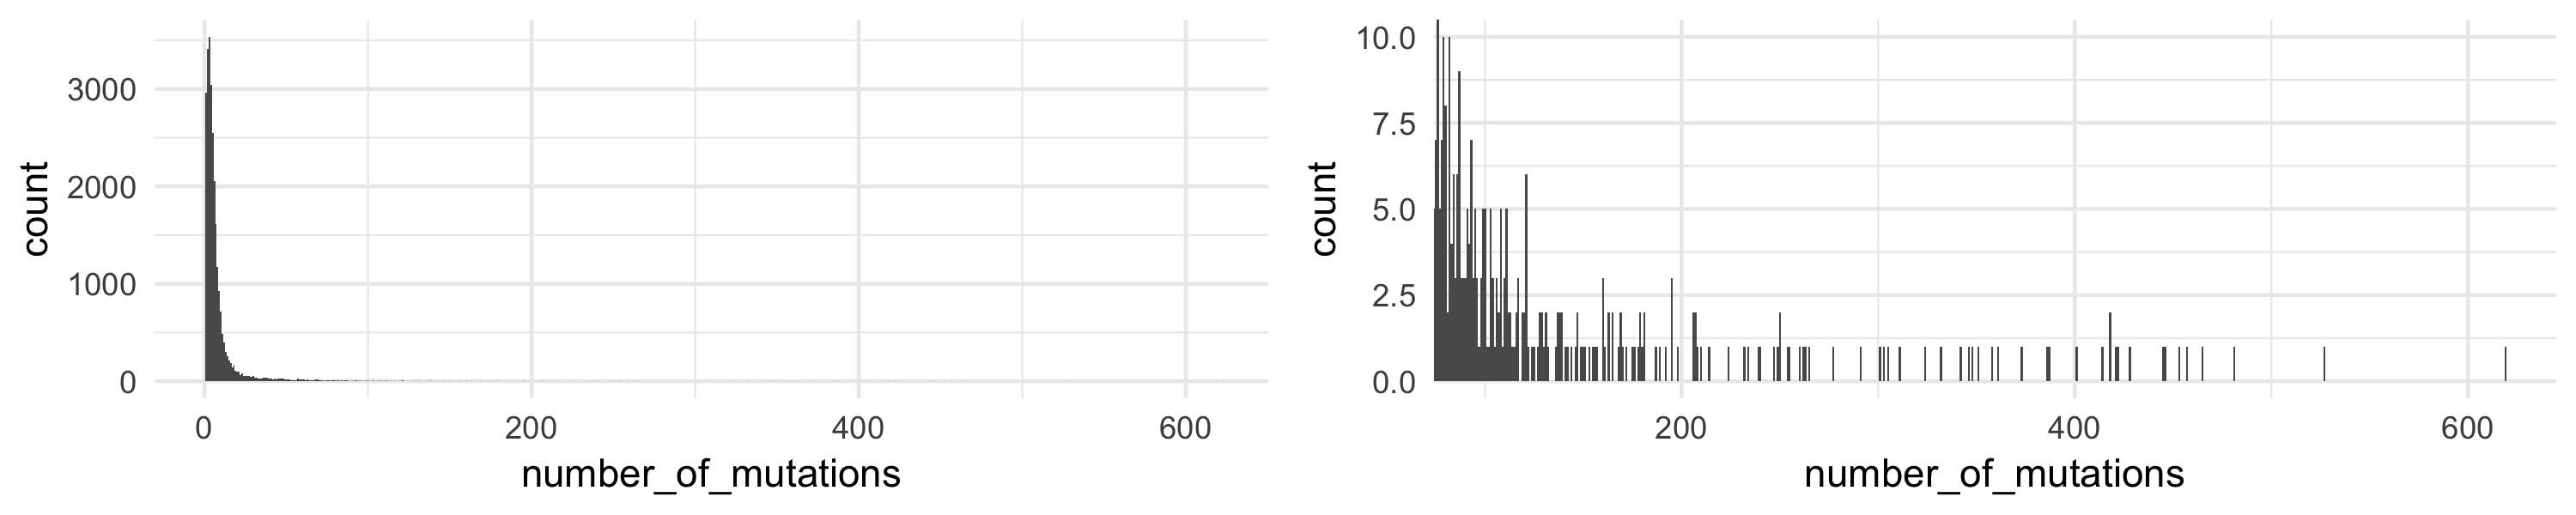

In [60]:
plot1 <- ggplot(tumor_sample_summary) + geom_histogram(aes(number_of_mutations), binwidth = 1)
plot2 <- plot1 + coord_cartesian(xlim = c(100, 619), ylim = c(0, 10))
plot_side_by_side(plot1, plot2)

We decided not to remove any hypermutated patient.

## [Remove] DNP and TNP counted twice

Some `SNP` are overlapped by a `DNP` or a `TNP`, we find them and remove them.

In [61]:
# pre-filter the tumor sample that could have overlapping snps and dnps/tnps
overlapping_risk_dnp_or_tnp <- as.data.frame(impact %>% group_by(Tumor_Sample_Barcode, VEP_SYMBOL) %>%
                                             filter(n() > 1 &
                                                    "SNP" %in% Variant_Type &
                                                    ("DNP" %in% Variant_Type |
                                                     "TNP" %in% Variant_Type)))

nrow(overlapping_risk_dnp_or_tnp)

[1] 8026

In [62]:
find_overlapping_dnp_or_tnp <- function(data, tsb, chr, start) {
    result <- data %>% filter(Tumor_Sample_Barcode == tsb &
                              Chromosome == chr &
                              ((Variant_Type == "DNP" & (Start_Position == start | Start_Position == start - 1) |
                               (Variant_Type == "TNP" & (Start_Position == start | Start_Position == start - 1 | Start_Position == start - 2)))))

    if (nrow(result) == 0)
        return ("no")
    else
        return (toString(paste(nrow(result), result$Start_Position, result$Reference_Allele, result$Tumor_Seq_Allele2, result$t_vaf, result$confidence_class, sep = ' | ')))
}

In [63]:
overlapping_dnp_or_tnp <- overlapping_risk_dnp_or_tnp %>% filter(Variant_Type == "SNP") %>%
                                                          group_by(sample_mut_key) %>%
                                                          mutate(overlap = find_overlapping_dnp_or_tnp(overlapping_risk_dnp_or_tnp, Tumor_Sample_Barcode, Chromosome, Start_Position)) %>%
                                                          filter(overlap != "no") %>%
                                                          select(sample_mut_key, VEP_SYMBOL, Start_Position, Variant_Type, Reference_Allele, Tumor_Seq_Allele2, Tumor_Sample_Barcode, t_vaf, confidence_class, overlap)

nrow(overlapping_dnp_or_tnp)

[1] 3841

In [64]:
head(overlapping_dnp_or_tnp)

sample_mut_key,VEP_SYMBOL,Start_Position,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Tumor_Sample_Barcode,t_vaf,confidence_class,overlap
P-0000088-T01-IM3_16_3801735_C_A,CREBBP,3801735,SNP,C,A,P-0000088-T01-IM3,0.10695,UNLIKELY,1 | 3801734 | GC | AA | 0.10738 | AUTO_OK
P-0000237-T01-IM3_20_31023626_G_A,ASXL1,31023626,SNP,G,A,P-0000237-T01-IM3,0.13000,UNLIKELY,1 | 31023625 | GG | AA | 0.13065 | AUTO_OK
P-0000293-T01-IM3_11_101984969_C_T,YAP1,101984969,SNP,C,T,P-0000293-T01-IM3,0.38117,UNLIKELY,1 | 101984968 | CC | TT | 0.38428 | AUTO_OK
P-0000316-T01-IM3_7_55221786_T_A,EGFR,55221786,SNP,T,A,P-0000316-T01-IM3,0.64133,UNLIKELY,1 | 55221785 | AT | GA | 0.64279 | AUTO_OK
P-0000426-T01-IM3_X_66937398_G_T,AR,66937398,SNP,G,T,P-0000426-T01-IM3,0.08219,UNLIKELY,1 | 66937397 | GG | TT | 0.08219 | AUTO_OK
P-0000427-T01-IM3_20_41306734_G_T,PTPRT,41306734,SNP,G,T,P-0000427-T01-IM3,0.18257,UNLIKELY,1 | 41306733 | GG | TT | 0.17732 | AUTO_OK


Most of them were classified as `UNLIKELY`:

In [65]:
get_table(overlapping_dnp_or_tnp$confidence_class)

values,count,freq
UNLIKELY,3736,97.3%
AUTO_OK,92,2.4%
MANUAL_OK,13,0.3%
-- total --,3841,100%


Except for a few, the `SNP` and the overlapping `DNP/TNP` have really close `t_vaf`:

In [66]:
overlapping_dnp_or_tnp$other_t_vaf <- sapply(overlapping_dnp_or_tnp$overlap, function(x) as.numeric(strsplit(x, ' \\| ')[[1]][5]))

In [67]:
get_table(abs(overlapping_dnp_or_tnp$t_vaf - overlapping_dnp_or_tnp$other_t_vaf) > 0.01)
get_table(abs(overlapping_dnp_or_tnp$t_vaf - overlapping_dnp_or_tnp$other_t_vaf) > 0.05)

values,count,freq
FALSE,3764,98%
TRUE,77,2%
-- total --,3841,100%


values,count,freq
FALSE,3833,99.8%
TRUE,8,0.2%
-- total --,3841,100%


In [68]:
# [-3,841 rows] remove the SNP found as DNP or TNP
impact <- impact[! impact$sample_mut_key %in% overlapping_dnp_or_tnp$sample_mut_key,]

# Process raw features

## [Modify] deal with `NA` values

In [67]:
count_na <- function(data) {
    return (sum(is.na(data)))
}

In [68]:
replace_na <- function(data, feature_name, replacement_value) {
    data[is.na(data[,feature_name]), feature_name] <- replacement_value
    
    return (data)
}

### VEP

In [69]:
for (c in vep_colnames)
    print(sprintf("%17s: %d", c, count_na(impact[,c])))

[1] "  VEP_Consequence: 0"
[1] "       VEP_SYMBOL: 0"
[1] "        VEP_HGVSc: 6"
[1] "        VEP_HGVSp: 8413"
[1] "VEP_VARIANT_CLASS: 0"


In [70]:
impact[is.na(impact$VEP_HGVSc),]

Hugo_Symbol    Chromosome Start_Position End_Position
83434  CDKN2Ap16INK4A 9          21974658       21974895    
265256 MAPK3          16         30134458       30135078    
266479 SMAD3          15         67457371       67457373    
331315 MSH2           2          47630177       47630419    
384985 AURKB          17          8108003        8108479    
577965 HLA-B          6          31324218       31325240    
       Consequence            Variant_Type
83434  splicing               DEL         
265256 nonsynonymous_SNV      DEL         
266479 nonframeshift_deletion DEL         
331315 nonsynonymous_SNV      DEL         
384985 splicing               DEL         
577965 splicing               DEL         
       Reference_Allele                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
83434  CTGCAGACCCTCTACCCACCTGGATCGGCCTCCGACCGTAACTATTCGGTGCGTTGGGCAGCGCCCCCGCCTCCAGCAGCGCCCGCACCTCCTCTACCCGACCCCGGGCCGCGGCCGTGGCCAGCCAGTCAGCCGAAGGCTCCATGCTGCTCCCCGCCGCCGGCTCCATGCTGCTCCCCGCCGCCCGCTGCCTGCTCTCCCCCTCTCCGCAGCCGCCGAGCGCACGCGGTCCGCCCCA                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
265256 GGACCCCCGGGCCGACCCCCTCGGTTCTACGGGGCTCCCCGCCCCCGCCCCCCTGAGCCGCCGCCGCCGCCATCTCCACTCCTCCCCTCCCACCGCCCTCCTCCCCACGGCGGCCCCGCCCGAGGCCCCGCCCCTTCCCGCCTGCCTGTCACCCGCAGGGCCGCGCGCGCCAGGCCCCGCCCTTGCCCCGGCCCCGCGTGGGCCTGGAGCTGTCACGTGACCCGCCCCGCGCGCGCCCGCCCTTCTTGCCCCAGGTTCGGGGGCCATGGGTCCCTGCGGGCTCCGCGGCCTCCAGGTCACCGGGAGGTTCGGCAGCGCCGCCTCGGAGACTGTCCTCACCCTCCCCTCGATGGCGAAGCGGCCAGGGCGTGACCTACCAGAGCCACCCAGCCAATGTATGCGGCAGCCCACCAGAACCTGGGCCCGGGATCACCCTAGGTTAAAAATAATGTTCTAATAAATGGATCAAATTTTACAGATGGAGAATCTGAGAGTTAGGTTTACTAACTTGGGTAAGGTCACTAGTAGTGACAGCTGAGACTCAAAATGGTGTCTTCTGACACAGAGACTCTTTCTAATTCCATGCCTCTCAGAGTCCTAGACTGTTTTTATTTTATTATA                                                                                                                                                                                                                                                                                                                                                                                                                  
266479 GAA                                                                                                                                                                                

8413 mutations have `VEP_HGVSp` = `NA`, almost all of them being splicing mutations:

In [71]:
get_table(impact$VEP_Consequence[is.na(impact$VEP_HGVSp)])

values,count,freq
splice_acceptor_variant,4348,51.7%
splice_donor_variant,3880,46.1%
frameshift_variant,90,1.1%
stop_lost,51,0.6%
start_lost,26,0.3%
inframe_insertion,7,0.1%
inframe_deletion,7,0.1%
stop_gained,4,0%
-- total --,8413,100%


In [72]:
nrow(impact[impact$VEP_Consequence == "splice_acceptor_variant" & ! is.na(impact$VEP_HGVSp) & impact$VEP_HGVSp != "unknown",])
nrow(impact[impact$VEP_Consequence == "splice_donor_variant"    & ! is.na(impact$VEP_HGVSp) & impact$VEP_HGVSp != "unknown",])

[1] 107

[1] 32

In [73]:
# [~ every rows] NA -> "unknown"
impact <- replace_na(impact, "VEP_HGVSc", "unknown")
impact <- replace_na(impact, "VEP_HGVSp", "unknown")

### VEP additional

In [74]:
for (c in vep_add_colnames)
    print(sprintf("%22s: %d", c, count_na(impact[,c])))

[1] "            VEP_IMPACT: 0"
[1] "VEP_Existing_variation: 118709"
[1] "          VEP_CLIN_SIG: 192133"
[1] "              VEP_SIFT: 65770"
[1] "          VEP_PolyPhen: 64816"
[1] "        VEP_COSMIC_CNT: 151448"


`NA` values might correspond to not found, we replace them by `"unknown"`:

In [75]:
# [~ every rows] NA -> "unknown"
impact <- replace_na(impact, "VEP_Existing_variation", "unknown")
impact <- replace_na(impact, "VEP_CLIN_SIG"          , "unknown")
impact <- replace_na(impact, "VEP_SIFT"              , "unknown")
impact <- replace_na(impact, "VEP_PolyPhen"          , "unknown")
impact <- replace_na(impact, "VEP_COSMIC_CNT"        , "unknown")

### VEP gnomAD

In [76]:
for (c in vep_gnomad_colnames)
    print(sprintf("%27s: %d", c, count_na(impact[,c])))

[1] "              VEP_gnomAD_AF: 181934"
[1] "VEP_gnomAD_genome_AC.AN_AFR: 211323"
[1] "VEP_gnomAD_genome_AC.AN_AMR: 211323"
[1] "VEP_gnomAD_genome_AC.AN_ASJ: 211323"
[1] "VEP_gnomAD_genome_AC.AN_EAS: 211323"
[1] "VEP_gnomAD_genome_AC.AN_FIN: 211323"
[1] "VEP_gnomAD_genome_AC.AN_NFE: 211323"
[1] "VEP_gnomAD_genome_AC.AN_OTH: 211323"
[1] " VEP_gnomAD_exome_AC.AN_AFR: 170539"
[1] " VEP_gnomAD_exome_AC.AN_AMR: 170539"
[1] " VEP_gnomAD_exome_AC.AN_ASJ: 170539"
[1] " VEP_gnomAD_exome_AC.AN_EAS: 170539"
[1] " VEP_gnomAD_exome_AC.AN_FIN: 170539"
[1] " VEP_gnomAD_exome_AC.AN_NFE: 170539"
[1] " VEP_gnomAD_exome_AC.AN_OTH: 170539"


`NA` values might correspond to not found, we replace them by a null allele value, or by `0 | 0` for the Allele count | Total number of alleles:

In [77]:
# [~ every rows] NA -> 0.0
impact <- replace_na(impact, "VEP_gnomAD_AF", 0.0)

# [~ every rows] NA -> "0 | 0"
for (c in vep_gnomad_colnames[grepl("_AC.AN_", vep_gnomad_colnames)])
    impact <- replace_na(impact, c, " 0 | 0")

## [Modify] `occurence_in_normals` -> `frequency_in_normals`

Ahmet:
> Each variant is evaluted in ~15 run-specific normals + 20 fixed normals. Unfortunately we only have the mixed information for now. And we only have the count in the normals, no VAF or other info.

The format is `'count;frequency'` or `'0'`. We consider the samples having `'0'` to have a frequency of 0, e.g. being `'0;0'`.

In [78]:
# find the non-matching patterns
unique(impact$occurence_in_normals[grep(pattern = "+;+", impact$occurence_in_normals, invert = TRUE)])
nrow(impact[impact$occurence_in_normals == '0',])

[1] "0"     "0.077" "0.083" "0.167" "0.154"

[1] 75025

In [79]:
# example of the transformation applied
dd <- head(unique(impact$occurence_in_normals), 10)
dd[dd == '0'] <- "0;0"
dd <- data.frame(dd, sapply(dd, function(s) as.double(strsplit(s, split = ';')[[1]][2])), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
0;0,0.000
0;0,0.000
1;0.026,0.026
6;0.158,0.158
3;0.079,0.079
4;0.105,0.105
7;0.184,0.184
2;0.051,0.051
3;0.077,0.077
7;0.179,0.179


174 values with different notation (missing the `;`), we will correct it:

In [80]:
nrow(impact[impact$occurence_in_normals != '0' & !grepl(';', impact$occurence_in_normals),])

[1] 174

In [81]:
# [~ every rows] occurence_in_normals -> frequency_in_normals
impact$occurence_in_normals[impact$occurence_in_normals == '0'] <- "0;0"
impact$occurence_in_normals[!grepl(';', impact$occurence_in_normals)] <- paste('0;', impact$occurence_in_normals[!grepl(';', impact$occurence_in_normals)])
impact$frequency_in_normals <- sapply(impact$occurence_in_normals,
                                      function(s) as.double(strsplit(s, split = ';')[[1]][2]))
impact$occurence_in_normals <- NULL

## [Modify] `VEP_HGVSc`

In [82]:
# example of the transformation applied
dd <- head(impact$VEP_HGVSc, 10)
dd <- data.frame(dd, sapply(dd, function(x) strsplit(x, ':')[[1]][2]), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
ENST00000269305.4:c.766A>C,c.766A>C
ENST00000262741.5:c.894C>G,c.894C>G
ENST00000350721.4:c.7292G>T,c.7292G>T
ENST00000257290.5:c.1393T>A,c.1393T>A
ENST00000281708.4:c.1237-1G>T,c.1237-1G>T
ENST00000281708.4:c.181G>T,c.181G>T
ENST00000264932.6:c.1444C>T,c.1444C>T
ENST00000399503.3:c.904G>T,c.904G>T
ENST00000399503.3:c.2087+2T>G,c.2087+2T>G
ENST00000439151.2:c.5338G>T,c.5338G>T


In [83]:
# [~ every rows] VEP_HGVSc -> readable VEP_HGVSc
impact$VEP_HGVSc <- sapply(impact$VEP_HGVSc, function(x) strsplit(x, ':')[[1]][2])
impact <- replace_na(impact, "VEP_HGVSc", "unknown") # 5 NA values that we need to handle

## [Modify] `VEP_HGVSp`

In [84]:
get_HGVSp_from_vep <- function(HGVSp_string) {
    
    if (HGVSp_string == "unknown")
        return ("unknown")
    
    HGVSp_string <- strsplit(HGVSp_string, ':')[[1]][2]
    
    protein_long_name <- c('Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Glu', 'Gln', 'Gly', 'His', 'Ile', 'Leu', 'Lys',
                           'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val')
    protein_short_name <- c('A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K',
                            'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V')
    
    for (name in protein_long_name)
        HGVSp_string <- gsub(name, protein_short_name[match(name, protein_long_name)], HGVSp_string)
    
    HGVSp_string <- gsub('Ter', '*', HGVSp_string)
    HGVSp_string <- gsub('%3D', '=', HGVSp_string)
    
    return (HGVSp_string)
}

# example of the transformation applied
dd <- head(impact$VEP_HGVSp, 10)
dd <- data.frame(dd, sapply(dd, get_HGVSp_from_vep), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
ENSP00000269305.4:p.Thr256Pro,p.T256P
ENSP00000262741.5:p.Ile298Met,p.I298M
ENSP00000343741.4:p.Arg2431Met,p.R2431M
ENSP00000257290.5:p.Leu465Met,p.L465M
unknown,unknown
ENSP00000281708.3:p.Gly61Ter,p.G61*
ENSP00000264932.6:p.Pro482Ser,p.P482S
ENSP00000382423.3:p.Glu302Ter,p.E302*
unknown,unknown
ENSP00000395929.2:p.Val1780Phe,p.V1780F


In [85]:
# [~ every rows] VEP_HGVSp -> readable VEP_HGVSp
impact$VEP_HGVSp <- sapply(impact$VEP_HGVSp, get_HGVSp_from_vep)

## [Modify] `VEP_SIFT`

In [86]:
# example of the transformation applied
dd <- head(unique(impact$VEP_SIFT), 10)
dd <- data.frame(dd,
                 sapply(dd, function(x) strsplit(x, '\\(')[[1]][1]),
                 sapply(dd, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2]))),
                 row.names = NULL)
colnames(dd) <- c("old", "new1", "new2")
dd

old,new1,new2
deleterious(0),deleterious,0.00
deleterious(0.01),deleterious,0.01
unknown,unknown,NA
tolerated_low_confidence(0.12),tolerated_low_confidence,0.12
tolerated(0.4),tolerated,0.40
tolerated(0.17),tolerated,0.17
deleterious(0.02),deleterious,0.02
deleterious_low_confidence(0),deleterious_low_confidence,0.00
tolerated_low_confidence(0.1),tolerated_low_confidence,0.10
tolerated(0.08),tolerated,0.08


In [87]:
# [~ every rows] VEP_SIFT -> VEP_SIFT_class & VEP_SIFT_score
impact$VEP_SIFT_class <- sapply(impact$VEP_SIFT, function(x) strsplit(x, '\\(')[[1]][1])
impact$VEP_SIFT_score <- sapply(impact$VEP_SIFT, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2])))
impact$VEP_SIFT <- NULL

Warning, there is `NA` values in `VEP_SIFT_score` for `unknown`.

## [Modify] `VEP_PolyPhen`

In [88]:
# example of the transformation applied
dd <- head(unique(impact$VEP_PolyPhen), 10)
dd <- data.frame(dd,
                 sapply(dd, function(x) strsplit(x, '\\(')[[1]][1]),
                 sapply(dd, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2]))),
                 row.names = NULL)
colnames(dd) <- c("old", "new1", "new2")
dd

old,new1,new2
probably_damaging(0.999),probably_damaging,0.999
benign(0.277),benign,0.277
probably_damaging(0.997),probably_damaging,0.997
probably_damaging(0.965),probably_damaging,0.965
unknown,unknown,NA
benign(0.005),benign,0.005
probably_damaging(0.952),probably_damaging,0.952
possibly_damaging(0.738),possibly_damaging,0.738
probably_damaging(0.995),probably_damaging,0.995
possibly_damaging(0.472),possibly_damaging,0.472


In [89]:
# [~ every rows] VEP_PolyPhen -> VEP_PolyPhen_class & VEP_PolyPhen_score
impact$VEP_PolyPhen_class <- sapply(impact$VEP_PolyPhen, function(x) strsplit(x, '\\(')[[1]][1])
impact$VEP_PolyPhen_score <- sapply(impact$VEP_PolyPhen, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2])))
impact$VEP_PolyPhen <- NULL

Warning, there is `NA` values in `VEP_PolyPhen_score` for `unknown`.

## [Modify] `VEP_Existing_variation` -> `VEP_in_dbSNP`

A mutation has the feature`VEP_in_dbSNP = TRUE` when we found a dnSNP id in the `VEP_Existing_variation` column.

In [90]:
# example of the transformation applied
dd <- head(unique(impact$VEP_Existing_variation), 10)
dd <- data.frame(dd, grepl("rs", dd), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
CM102355&CD120857&TP53_g.13403A>C&COSM44544&COSM44662&COSM45526&COSM45830,FALSE
unknown,FALSE
rs759327414&COSM1039347,TRUE
rs775630094&COSM3782296&COSM3782297&COSM3782298&COSM3782299&COSM3782300&COSM3782301,TRUE
COSM5570654&COSM5570655&COSM5570656,FALSE
COSM3693022&COSM4784258,FALSE
COSM1589625&COSM990757,FALSE
COSM5586358&COSM5586359,FALSE
COSM4599799,FALSE
COSM44939&COSM46097,FALSE


In [91]:
# [~ every rows] VEP_Existing_variation -> VEP_in_dbSNP
impact$VEP_in_dbSNP <- grepl("rs", impact$VEP_Existing_variation)
impact$VEP_Existing_variation <- NULL

## [Modify] `VEP_COSMIC_CNT`

In [92]:
get_cosmic_count_from_vep <- function(cosmic_count_string) {
    if (cosmic_count_string == "unknown")
        return (0)
    else
        return (sum(as.numeric(strsplit(cosmic_count_string, '&')[[1]])))
}

# example of the transformation applied
dd <- head(unique(impact$VEP_COSMIC_CNT), 10)
dd <- data.frame(dd, sapply(dd, get_cosmic_count_from_vep), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
1,1
unknown,0
1&1&1&1&1&1,6
1&1&1,3
1&1,2
53,53
158,158
19&21&14,54
229&230&200&230&179&789,1857
42&170,212


In [93]:
# [~ every rows] VEP_COSMIC_CNT -> readable VEP_COSMIC_CNT
impact$VEP_COSMIC_CNT <- sapply(impact$VEP_COSMIC_CNT, get_cosmic_count_from_vep)

## [Modify] VEP_CLIN_SIG

In [94]:
get_table(impact$VEP_CLIN_SIG) %>% filter(count >= 200)

values,count,freq
unknown,192133,85.2%
likely_pathogenic&pathogenic,9707,4.3%
not_provided&likely_pathogenic&pathogenic,5707,2.5%
pathogenic,4216,1.9%
likely_pathogenic,3790,1.7%
uncertain_significance,3577,1.6%
uncertain_significance&likely_pathogenic,983,0.4%
uncertain_significance&pathogenic,734,0.3%
likely_pathogenic&pathogenic&drug_response,679,0.3%
uncertain_significance&likely_pathogenic&pathogenic,630,0.3%


We group the values with the following rules:
* We consider 3 big different classes:
    * `pathogenic`: `pathogenic`, `likely_pathogenic`, `drug_response`, `risk_factor`
    * `benign`: `benign`, `likely_benign`
    * `unknown`: `NA` (has been previously replaced by `unknown`), `not_provided`, `uncertain_significance`
* A mutation having both `pathogenic` and `benign` classes is classified as `unknown`
* A mutation having a strong class (`pathogenic` or `benign`) and `unknown` class is classified as the strong class

In [95]:
get_simplified_clin_sig <- function(clin_sig_string) {
    if (clin_sig_string == "unknown")
        return ("unknown")
    else {
        tags <- unique(strsplit(clin_sig_string, '&')[[1]])
        
        tags <- gsub('likely_pathogenic', 'pathogenic', tags)
        tags <- gsub('drug_response'    , 'pathogenic', tags)
        tags <- gsub('risk_factor'      , 'pathogenic', tags)
        tags <- gsub('likely_benign'    , 'benign'    , tags)
        
        tags <- unique(tags)
        
        tags <- tags[! tags %in% c("not_provided", "uncertain_significance", "other")]
        
        if (length(tags) == 0 || length(tags) > 1)
            return ("unknown")
        else
            return (tags)
    }
}

# example of the transformation applied
dd <- head(unique(impact$VEP_CLIN_SIG), 20)
dd <- data.frame(dd, sapply(dd, get_simplified_clin_sig), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
unknown,unknown
likely_pathogenic&pathogenic,pathogenic
uncertain_significance&pathogenic,pathogenic
likely_pathogenic,pathogenic
not_provided&likely_pathogenic&pathogenic,pathogenic
pathogenic,pathogenic
uncertain_significance&likely_pathogenic,pathogenic
not_provided,unknown
uncertain_significance,unknown
uncertain_significance&likely_pathogenic&pathogenic,pathogenic


In [96]:
# [~ every rows] VEP_CLIN_SIG -> readable VEP_CLIN_SIG
impact$VEP_CLIN_SIG <- sapply(impact$VEP_CLIN_SIG, get_simplified_clin_sig)

In [97]:
get_table(impact$VEP_CLIN_SIG)

values,count,freq
unknown,196789,87.2%
pathogenic,27972,12.4%
benign,800,0.4%
-- total --,225561,100%


## [Modify & Create & Remove] vep_gnomad_colnames

In [98]:
pop_names <- c('AFR', 'AMR', 'ASJ', 'EAS', 'FIN', 'NFE', 'OTH')

### `genome_AC.AN_<POP>` & `exome_AC.AN_<POP>` -> `total_AC.AN_<POP>`

For each population, we sum the allele count (`AC`) and total allele number (`AN`) on the exomes and the genomes. This operation creates 7 new features named `VEP_gnomAD_total_AC.AN_<POP>`.

In [99]:
get_gnomAD_total_AC.AN_pop <- function(data, pop_name) {
    genome_AC = as.integer(strsplit(data[paste0("VEP_gnomAD_genome_AC.AN_", pop_name)], ' \\| ')[[1]][1])
    genome_AN = as.integer(strsplit(data[paste0("VEP_gnomAD_genome_AC.AN_", pop_name)], ' \\| ')[[1]][2])

    exome_AC = as.integer(strsplit(data[paste0("VEP_gnomAD_exome_AC.AN_", pop_name)], ' \\| ')[[1]][1])
    exome_AN = as.integer(strsplit(data[paste0("VEP_gnomAD_exome_AC.AN_", pop_name)], ' \\| ')[[1]][2])
    
    return (paste(genome_AC + exome_AC, genome_AN + exome_AN, sep = ' | '))
}

In [100]:
# example of the transformation applied
dd <- tail(unique(impact[, c("VEP_gnomAD_genome_AC.AN_AFR", "VEP_gnomAD_exome_AC.AN_AFR")]), 10)
dd <- data.frame(dd, apply(dd, 1, function(x) get_gnomAD_total_AC.AN_pop(x, "AFR")), row.names = NULL)
colnames(dd) <- c("genome_AC.AN_AFR", "exome_AC.AN_AFR", "new (total_AC.AN_AFR)")
dd

genome_AC.AN_AFR,exome_AC.AN_AFR,new (total_AC.AN_AFR)
0 | 8140,0 | 15022,0 | 23162
5 | 8686,2 | 15304,7 | 23990
1 | 8730,0 | 15014,1 | 23744
0 | 0,1 | 13232,1 | 13232
5 | 8608,3 | 7828,8 | 16436
0 | 0,1 | 1970,1 | 1970
1 | 8702,1 | 15302,2 | 24004
3 | 8600,1 | 15014,4 | 23614
0 | 5927,0 | 12245,0 | 18172
1 | 8706,1 | 15276,2 | 23982


In [101]:
# [+7 features] VEP_gnomAD_total_AC.AN_<POP> (temporary feature)
for (pop in pop_names)
    impact[, paste0("VEP_gnomAD_total_AC.AN_", pop)] <- apply(impact, 1, function(x) get_gnomAD_total_AC.AN_pop(x, pop))

### `total_AC.AN_<POP>` -> `total_AF_<POP>`

Foe each population, we convert `VEP_gnomAD_total_AC.AN_<POP>` to the corresponding allele frequency (`AF`), the allele frequency of the mutation in gnomAD exomes and genomes united. This operation creates 7 new features named `VEP_gnomAD_total_AF_<POP>`.

In [102]:
get_gnomAD_total_AF_pop <- function(data, pop_name) {
        
    AC = as.integer(strsplit(data[paste0("VEP_gnomAD_total_AC.AN_", pop_name)], ' \\| ')[[1]][1])
    AN = as.integer(strsplit(data[paste0("VEP_gnomAD_total_AC.AN_", pop_name)], ' \\| ')[[1]][2])
    
    if (AN == 0)
        return (0)
    else
        return (AC / AN)
}

# example of the transformation applied
dd <- tail(unique(impact[, c("VEP_gnomAD_total_AC.AN_AFR",
                             "VEP_gnomAD_total_AC.AN_AMR")]), 10)
dd <- data.frame(dd, apply(dd, 1, function(x) get_gnomAD_total_AF_pop(x, "AFR")),
                     apply(dd, 1, function(x) get_gnomAD_total_AF_pop(x, "AMR")), row.names = NULL)
colnames(dd) <- c("total_AC.AN_AFR", "total_AC.AN_AMR", "new1 (total_AF_AFR)", "new2 (total_AF_AMR)")
dd

total_AC.AN_AFR,total_AC.AN_AMR,new1 (total_AF_AFR),new2 (total_AF_AMR)
2 | 15304,3 | 33574,1.306848e-04,8.935486e-05
1 | 1970,0 | 17164,5.076142e-04,0.000000e+00
0 | 15068,2 | 33448,0.000000e+00,5.979431e-05
2 | 24004,0 | 34412,8.331945e-05,0.000000e+00
4 | 23614,5 | 34304,1.693910e-04,1.457556e-04
0 | 15172,1 | 32482,0.000000e+00,3.078628e-05
0 | 18172,0 | 27197,0.000000e+00,0.000000e+00
1 | 24018,0 | 34308,4.163544e-05,0.000000e+00
2 | 23982,0 | 34268,8.339588e-05,0.000000e+00
0 | 14040,0 | 32410,0.000000e+00,0.000000e+00


In [103]:
# [+7 features] VEP_gnomAD_total_AF_<POP>
for (pop in pop_names)
    impact[, paste0("VEP_gnomAD_total_AF_", pop)] <- apply(impact, 1, function(x) get_gnomAD_total_AF_pop(x, pop))

### `total_AC.AN_<POP>` -> `VEP_gnomAD_total_AF_max`

We calculate the maximal `AF` among all 7 populations, for gnomAD exomes and genomes united. This operation creates 1 new feature named `VEP_gnomAD_total_AF_max`.

In [104]:
# example of the transformation applied
dd <- tail(unique(impact[, c("VEP_gnomAD_total_AF_AFR",
                             "VEP_gnomAD_total_AF_AMR")]), 10)

total_AF_columns <- colnames(dd)[grepl("VEP_gnomAD_total_AF_", colnames(dd))]

dd <- data.frame(dd, apply(dd, 1, function(x) max(as.numeric(x[total_AF_columns]))), row.names = NULL)
colnames(dd) <- c("total_AF_AFR", "total_AF_AMR", "new")
dd

total_AF_AFR,total_AF_AMR,new
3.415884e-04,5.409792e-05,3.415884e-04
2.917882e-04,1.452813e-04,2.917882e-04
4.211590e-05,0.000000e+00,4.211590e-05
7.557437e-05,3.123438e-05,7.557437e-05
4.867364e-04,8.052178e-05,4.867364e-04
1.306848e-04,8.935486e-05,1.306848e-04
5.076142e-04,0.000000e+00,5.076142e-04
0.000000e+00,5.979431e-05,5.979431e-05
1.693910e-04,1.457556e-04,1.693910e-04
0.000000e+00,3.078628e-05,3.078628e-05


In [105]:
# [+1 feature] VEP_gnomAD_total_AF_max
total_AF_columns <- colnames(impact)[grepl("VEP_gnomAD_total_AF_", colnames(impact))]
impact$VEP_gnomAD_total_AF_max <- apply(impact, 1, function(x) max(as.numeric(x[total_AF_columns])))

### `total_AC.AN_<POP>` -> `VEP_gnomAD_total_AF`

We calculate the `AF` among all 7 populations, for gnomAD exomes and genomes united. This operation creates 1 new feature named `VEP_gnomAD_total_AF`.

In [106]:
get_gnomAD_total_AF <- function(data) {
    
    AC <- c()
    AN <- c()
    
    for (pop in pop_names) {
        AC <- c(AC, as.integer(strsplit(data[paste0("VEP_gnomAD_total_AC.AN_", pop)], ' \\| ')[[1]][1]))
        AN <- c(AN, as.integer(strsplit(data[paste0("VEP_gnomAD_total_AC.AN_", pop)], ' \\| ')[[1]][2]))
    }
                
    if (sum(AN) == 0)
        return (0)
    else
        return (sum(AC) / sum(AN))
}

# example of the transformation applied

total_AC.AN_columns <- colnames(impact)[grepl("VEP_gnomAD_total_AC.AN_", colnames(impact))]

dd <- tail(unique(impact[, total_AC.AN_columns]), 10)
dd <- data.frame(dd, apply(dd, 1, get_gnomAD_total_AF), row.names = NULL)
colnames(dd) <- c(total_AC.AN_columns, "new")
dd

VEP_gnomAD_total_AC.AN_AFR,VEP_gnomAD_total_AC.AN_AMR,VEP_gnomAD_total_AC.AN_ASJ,VEP_gnomAD_total_AC.AN_EAS,VEP_gnomAD_total_AC.AN_FIN,VEP_gnomAD_total_AC.AN_NFE,VEP_gnomAD_total_AC.AN_OTH,new
4 | 23614,5 | 34304,1 | 10074,1 | 18780,0 | 24686,3 | 123054,0 | 6380,5.811733e-05
0 | 15302,0 | 33582,12 | 9850,0 | 17248,0 | 22276,2 | 111616,0 | 5484,6.500803e-05
0 | 15304,0 | 33582,0 | 9848,0 | 17248,0 | 22290,1 | 111634,0 | 5484,4.642741e-06
0 | 24022,1 | 34412,0 | 10150,2 | 18850,2 | 25618,1 | 126622,0 | 6462,2.437677e-05
0 | 15172,1 | 32482,0 | 9452,0 | 17064,0 | 22104,0 | 110108,0 | 5334,4.723309e-06
0 | 18172,0 | 27197,0 | 7483,1 | 13911,0 | 19014,0 | 90671,0 | 4784,5.517789e-06
1 | 24018,0 | 34308,0 | 9990,0 | 18838,0 | 25670,3 | 125548,0 | 6432,1.633960e-05
2 | 23982,0 | 34268,0 | 9992,0 | 18848,0 | 23106,0 | 124764,0 | 6410,8.286034e-06
0 | 14040,0 | 32410,0 | 9366,0 | 16446,1 | 19682,2 | 105658,0 | 5120,1.479859e-05
1 | 15290,0 | 33574,0 | 9834,0 | 17238,6 | 22300,0 | 111394,0 | 5478,3.254179e-05


In [107]:
# [+1 feature] VEP_gnomAD_total_AF
impact$VEP_gnomAD_total_AF <- apply(impact, 1, get_gnomAD_total_AF)

### Results

Here is a comparison plot between `VEP_gnomAD_AF` vs `VEP_gnomAD_total_AF` on the left, and `VEP_gnomAD_total_AF` vs `VEP_gnomAD_total_AF_max` on the right:

Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”

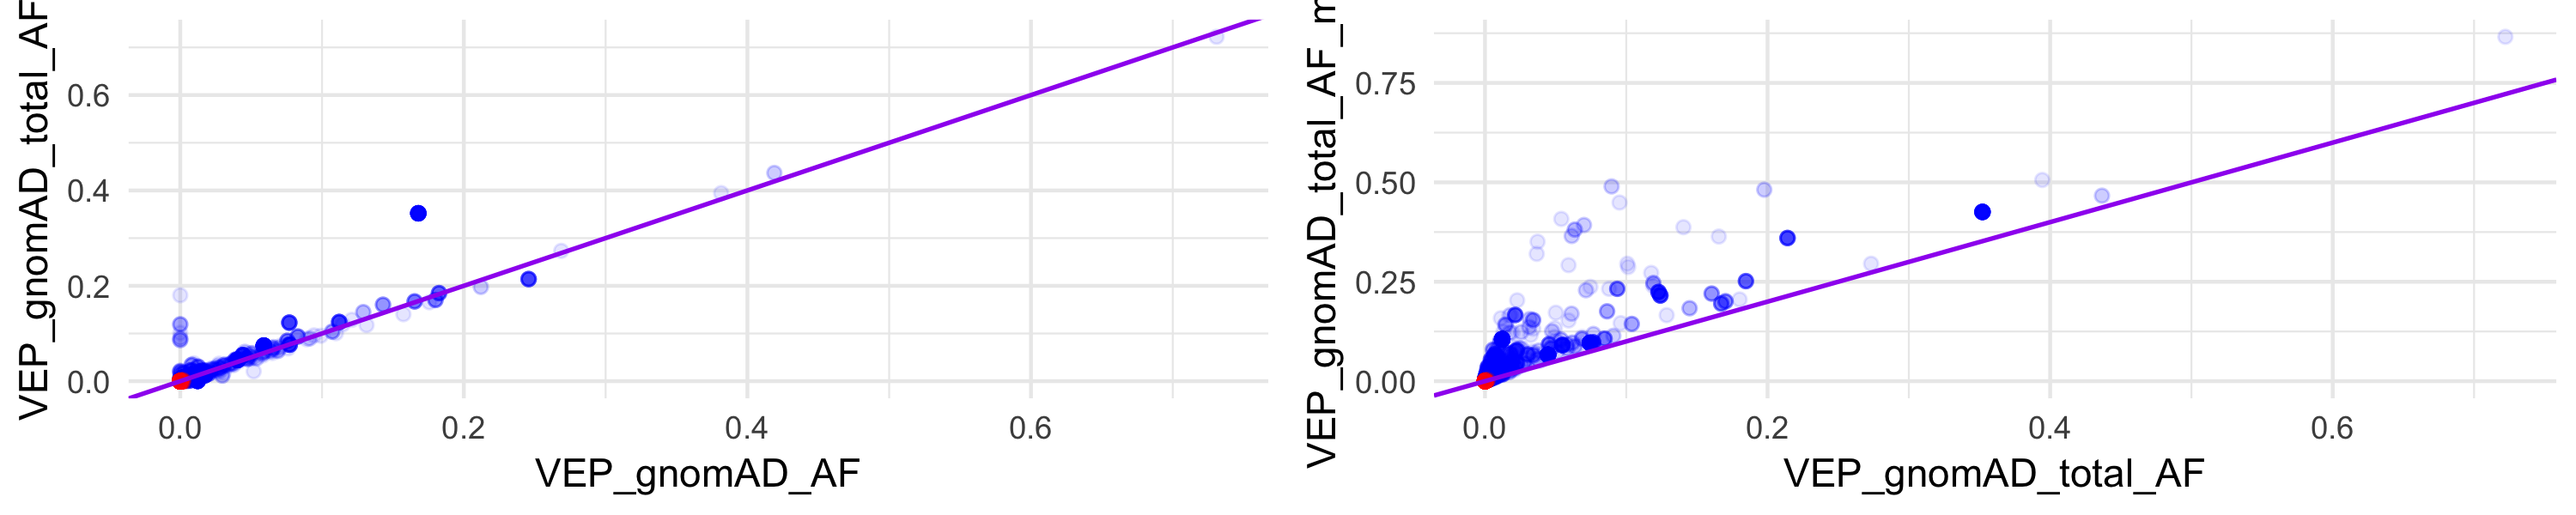

In [108]:
plot1 <- plot_density_2d(impact, "VEP_gnomAD_AF", "VEP_gnomAD_total_AF", points_only = TRUE, height = 2) + geom_abline(intercept = 0, slope = 1, color ="purple", size = 0.6)
plot2 <- plot_density_2d(impact, "VEP_gnomAD_total_AF", "VEP_gnomAD_total_AF_max", points_only = TRUE, height = 2) + geom_abline(intercept = 0, slope = 1, color ="purple", size = 0.6)
plot_side_by_side(plot1, plot2)

We remove the features we won't use, ie:
* `VEP_gnomAD_genome_AC.AN_<POP>`: 7 features
* `VEP_gnomAD_exome_AC.AN_<POP>`: 7 features
* `VEP_gnomAD_total_AC.AN_<POP>`: 7 features

In [109]:
# [-21 features] remove VEP_gnomAD_genome_AC.AN_<POP>, VEP_gnomAD_exome_AC.AN_<POP> and VEP_gnomAD_total_AC.AN_<POP>
impact <- impact[, colnames(impact)[! (grepl("VEP_gnomAD_genome_AC.AN", colnames(impact)) |
                                       grepl("VEP_gnomAD_exome_AC.AN", colnames(impact)) |
                                       grepl("VEP_gnomAD_total_AC.AN", colnames(impact)))]]

In [110]:
vep_gnomad_colnames <- c("VEP_gnomAD_AF",
                         "VEP_gnomAD_total_AF_AFR",
                         "VEP_gnomAD_total_AF_AMR",
                         "VEP_gnomAD_total_AF_ASJ",
                         "VEP_gnomAD_total_AF_EAS",
                         "VEP_gnomAD_total_AF_FIN",
                         "VEP_gnomAD_total_AF_NFE",
                         "VEP_gnomAD_total_AF_OTH",
                         "VEP_gnomAD_total_AF_max",
                         "VEP_gnomAD_total_AF")

## [Modify] `variant_caller_cv`

Table gave by Ahmet:

| `variant_caller_cv` | caller combination   |
| ------------------- | -------------------- |
| 1                   | MUTECT_ANNOVAR       |
| 2                   | SOMATICINDEL_ANNOVAR |
| 3                   | PINDEL_ANNOVAR       |
| 4                   | SID_PINDEL_ANNOVAR   |
| 5                   | UNKNOWN              |
| 6                   | HTC                  |
| 7                   | MutectHTC            |
| 8                   | MUTECT_VARDICT       |
| 9                   | PINDEL_VARDICT       |
| 10                  | SID_PINDEL_VARDICT   |
| 11                  | SID_VARDICT          |
| 12                  | VARDICT              |

In [111]:
variant_caller_table <- c("MUTECT_ANNOVAR",
                          "SOMATICINDEL_ANNOVAR",
                          "PINDEL_ANNOVAR",
                          "SID_PINDEL_ANNOVAR",
                          "UNKNOWN",
                          "HTC",
                          "MutectHTC",
                          "MUTECT_VARDICT",
                          "PINDEL_VARDICT",
                          "SID_PINDEL_VARDICT",
                          "SID_VARDICT",
                          "VARDICT")

# example of the transformation applied
dd <- head(unique(impact$variant_caller_cv), 10)
dd <- data.frame(dd, sapply(dd, function(x) variant_caller_table[x]), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old,new
1,MUTECT_ANNOVAR
2,SOMATICINDEL_ANNOVAR
3,PINDEL_ANNOVAR
4,SID_PINDEL_ANNOVAR
5,UNKNOWN
12,VARDICT
11,SID_VARDICT
8,MUTECT_VARDICT
9,PINDEL_VARDICT
10,SID_PINDEL_VARDICT


In [112]:
# [~ every rows] variant_caller_cv -> readable variant_caller_cv
impact$variant_caller_cv <- sapply(impact$variant_caller_cv, function(x) variant_caller_table[x])

# Test `get_final_dataset()`

In [113]:
final_impact <- read.table("../../data/processed/final_IMPACT_mutations_20181105.txt",
                           sep = "\t", stringsAsFactors = FALSE, header = TRUE, comment = "#")

In [114]:
nrow(impact)
nrow(final_impact)

[1] 225561

[1] 225561

Except for the rownames the two dataframes (the one obtained by the notebook and the one obtained with the script) are equal:

In [115]:
all.equal(impact, final_impact)

[1] "Attributes: < Component “row.names”: Mean relative difference: 0.6518961 >"